In [479]:
import torch

if torch.cuda.is_available():
    print("CUDA is available on this machine.")
    device = torch.device("cuda")
else:
    print("CUDA is not available on this machine.")
    device = torch.device("cpu")


CUDA is available on this machine.


In [480]:
#from google.colab import drive
#drive.mount('/content/drive')


In [481]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [482]:
class LGBMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(LGBMModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [483]:
class ComplexLGBMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3):
        super(ComplexLGBMModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim2)  # Adding an extra hidden layer
        self.fc5 = nn.Linear(hidden_dim2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))  # Passing through the extra hidden layer
        x = self.sigmoid(self.fc5(x))
        return x


In [484]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(fpr, tpr, roc_auc, label):
    plt.plot(fpr, tpr, lw=2, label='{} (area = {:.2f})'.format(label, roc_auc))

In [485]:
def drop_low_weight_nodes(model, input_dim, hidden_dim1, hidden_dim2):
    pruned_model = LGBMModel(input_dim, hidden_dim1, hidden_dim2)
    pruned_model.load_state_dict(model.state_dict())

    # Get weights of the first hidden layer
    weights_fc1 = pruned_model.fc1.weight.data

    # Get weights of the second hidden layer
    weights_fc2 = pruned_model.fc2.weight.data

    # Iterate through nodes in the second hidden layer
    for i in range(weights_fc2.size(0)):
        if torch.all(weights_fc2[i] < weights_fc1[:, i]):
            # If all weights of the node in the second hidden layer are below the weights
            # of the corresponding node in the first hidden layer, set the weights to zero
            pruned_model.fc2.weight.data[i].fill_(0.0)

    return pruned_model


In [486]:
class ImputerNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ImputerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [487]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def nn_impute(data, num_epochs=1000, learning_rate=0.001):
    if data.isnull().sum().sum() == 0:
        print("No NaN values found in the data.")
        return data

    print("Nan Values are present in this DataFrame - Imputation started")

    # Convert DataFrame to PyTorch tensor
    data_tensor = torch.tensor(data.values, dtype=torch.float32)

    # Replace NaN values with zeros
    data_tensor = torch.where(torch.isnan(data_tensor), torch.tensor(0.0), data_tensor)

    # Create the NN imputer
    input_dim = data.shape[1]
    output_dim = data.shape[1]  # Number of features
    imputer = ImputerNN(input_dim, output_dim)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(imputer.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        imputed_data = imputer(data_tensor)
        loss = criterion(imputed_data, data_tensor)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

    # Get the imputed data
    imputed_data = imputer(data_tensor)

    # Convert back to a numpy array
    imputed_data_np = imputed_data.detach().numpy()

    # Create a DataFrame with imputed values
    imputed_df = pd.DataFrame(imputed_data_np, columns=data.columns)

    return imputed_df

def impute_and_cluster(data, num_clusters=2):
    # Impute missing values using CNN-based method
    imputed_data = nn_impute(data)

    # Standardize the imputed data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(imputed_data)

    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(standardized_data)

    # Apply fuzzy c-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(reduced_data)
    cluster_centers_indices, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, reduced_data)

    return imputed_data, reduced_data, kmeans.labels_, cluster_centers_indices

In [488]:
def save_model(model, model_name):
    # Add .pth extension to the model name
    model_name_with_extension = model_name + '.pth'

    # Save the trained model
    torch.save(model.state_dict(), model_name_with_extension)

In [489]:
def interpretation(train_data, test_data, train_labels, test_labels, model_type, feature_importance_type,model_name, shuffle_percent=None):
    imputed_train, reduced_data_train, cluster_labels_train, cluster_centers_indices_trian= impute_and_cluster(train_data)
    imputed_test, reduced_data_test, cluster_labels_test, cluster_centers_indices_test= impute_and_cluster(test_data)
    from sklearn.model_selection import train_test_split
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(imputed_train)
    test_normlized=scaler.fit_transform(imputed_test)
    X_train, X_val, y_train, y_val = train_test_split(X_normalized, train_labels, test_size=0.25, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
    #test_data_tensor = torch.tensor(imputed_test.values, dtype=torch.float32)
    #test_data_tensor = torch.tensor(test_normlized, dtype=torch.float32)

    # Define model architectures based on model_type
    num_features = X_train.shape[1]
    if model_type == "lgbm":
        test_data_tensor = torch.tensor(imputed_test.values, dtype=torch.float32)
        lgbm_model = ComplexLGBMModel(input_dim=num_features, hidden_dim1=256, hidden_dim2=64,hidden_dim3=16)
        optimizer = optim.SGD(lgbm_model.parameters(), lr=0.0001)
        num_epochs = 100
        criterion = nn.MSELoss()
    elif model_type == "lgbm_blood":
        test_data_tensor = torch.tensor(test_normlized, dtype=torch.float32)
        lgbm_model = ImprovedModel(input_dim=num_features, hidden_dim1=256, hidden_dim2=64,hidden_dim3=16)
        optimizer = optim.Adagrad(lgbm_model.parameters(), lr=0.0001)
        num_epochs = 1000

        criterion = nn.MSELoss()  # Binary Cross-Entropy loss

    # Training loop
    batch_size = 64
    print("Started Model Training and Optimzation")
    for epoch in range(num_epochs):
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = lgbm_model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
          print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the model
    lgbm_model.eval()
    with torch.no_grad():
        preds = lgbm_model(test_data_tensor)
        preds = preds.numpy()

    # Calculate accuracy
    if model_type == "lgbm":
      threshold = 0.8  # Adjust the threshold as needed
    elif model_type =="lgbm_blood":
      threshold=0.6
    predicted_labels = (preds > threshold).astype(int)
    true_labels = test_labels.values
    accuracy = np.mean(predicted_labels == true_labels)

    # Evaluate the model using ROC AUC
    roc_auc = roc_auc_score(true_labels, preds)

    print("Accuracy:", accuracy)
    print("ROC AUC:", roc_auc)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(true_labels, preds)

    # Plot ROC curve
    plot_roc_curve(fpr, tpr, roc_auc, 'Original Data')
    #Save model

    save_model(lgbm_model, model_name)
    if shuffle_percent:
        # Shuffle a percentage of the data
        shuffled_indices = np.random.choice(len(X_train_tensor), size=int(len(X_train_tensor) * shuffle_percent), replace=False)
        X_train_tensor[shuffled_indices] = X_train_tensor[shuffled_indices][torch.randperm(len(shuffled_indices))]
        y_train_tensor[shuffled_indices] = y_train_tensor[shuffled_indices][torch.randperm(len(shuffled_indices))]

        # Training loop with shuffled data
        batch_size = 64
        num_epochs = 100  # Adjust as needed

        for epoch in range(num_epochs):
            for i in range(0, len(X_train_tensor), batch_size):
                batch_X = X_train_tensor[i:i+batch_size]
                batch_y = y_train_tensor[i:i+batch_size]

                optimizer.zero_grad()
                outputs = lgbm_model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

            # Evaluate the model with shuffled data
            lgbm_model.eval()
            with torch.no_grad():
                preds_shuffled = lgbm_model(test_data_tensor)
                preds_shuffled = preds_shuffled.numpy()

            # Evaluate the model using ROC AUC with shuffled data
            roc_auc_shuffled = roc_auc_score(true_labels, preds_shuffled)

        # Calculate ROC curve with shuffled data
        fpr_shuffled, tpr_shuffled, _ = roc_curve(true_labels, preds_shuffled)

        # Plot ROC curve for shuffled data
        plot_roc_curve(fpr_shuffled, tpr_shuffled, roc_auc_shuffled, f'{int(shuffle_percent*100)}% Shuffled Data')

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    return fpr, tpr, preds



Covid Data Run


In [ ]:
train_data = pd.read_csv('./Data/train_data.csv')
test_data = pd.read_csv('./Data/test_data.csv')
train_labels = pd.read_csv('./Data/train_labels.csv')
test_labels = pd.read_csv('./Data/test_labels.csv')

Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 0.1188
Epoch [100/1000], Loss: 0.0001
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 0.1124
Epoch [100/1000], Loss: 0.0001
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Started Model Training and Optimzation
Epoch [0/100], Loss: 0.2311
Accuracy: 0.9248689695018778
ROC AUC: 0.875501927129209


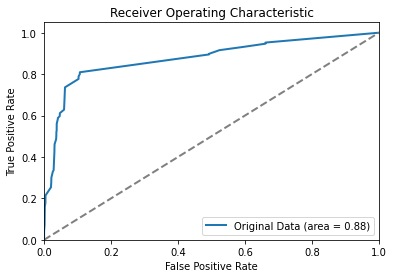

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.23109703e-05,
        2.23109703e-05, 4.46219406e-05, 4.46219406e-05, 4.46219406e-05,
        4.46219406e-05, 4.46219406e-05, 4.46219406e-05, 4.46219406e-05,
        4.46219406e-05, 4.46219406e-05, 4.46219406e-05, 6.69329109e-05,
        6.69329109e-05, 6.69329109e-05, 1.45021307e-03, 1.45021307e-03,
        1.47252404e-03, 1.51714598e-03, 1.62870083e-03, 1.62870083e-03,
        1.65101180e-03, 1.65101180e-03, 1.67332277e-03, 1.67332277e-03,
        1.71794471e-03, 1.74025568e-03, 1.74025568e-03, 1.74025568e-03,
        1.74025568e-03, 1.74025568e-03, 2.16416412e-03, 2.16416412e-03,
        2.16416412e-03, 2.20878606e-03, 2.23109703e-03, 2.23109703e-03,
        2.23109703e-03, 2.23109703e-03, 2.23109703e-03, 2.231097

In [ ]:
# Example usage
# train_data = pd.read_csv('/content/drive/MyDrive/Deep learning/Project/Data/train_data.csv')
# test_data = pd.read_csv('/content/drive/MyDrive/Deep learning/Project/Data/test_data.csv')
# train_labels = pd.read_csv('/content/drive/MyDrive/Deep learning/Project/Data/train_labels.csv')
# test_labels = pd.read_csv('/content/drive/MyDrive/Deep learning/Project/Data/test_labels.csv')
model_type = "lgbm"
feature_importance_type = "..."
model_name="Covid_model"
interpretation(train_data, test_data, train_labels, test_labels, model_type, feature_importance_type,model_name, shuffle_percent=None)

Nan Values are presnt in this Dataframe - Imputation started
Epoch [0/1000], Loss: 0.1477
Epoch [100/1000], Loss: 0.0865
Epoch [200/1000], Loss: 0.0568
Epoch [300/1000], Loss: 0.0402
Epoch [400/1000], Loss: 0.0301
Epoch [500/1000], Loss: 0.0231
Epoch [600/1000], Loss: 0.0177
Epoch [700/1000], Loss: 0.0135
Epoch [800/1000], Loss: 0.0101
Epoch [900/1000], Loss: 0.0074


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Nan Values are presnt in this Dataframe - Imputation started
Epoch [0/1000], Loss: 0.1258
Epoch [100/1000], Loss: 0.0549
Epoch [200/1000], Loss: 0.0378
Epoch [300/1000], Loss: 0.0266
Epoch [400/1000], Loss: 0.0183
Epoch [500/1000], Loss: 0.0124
Epoch [600/1000], Loss: 0.0083
Epoch [700/1000], Loss: 0.0055
Epoch [800/1000], Loss: 0.0036
Epoch [900/1000], Loss: 0.0024


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch [0/100], Loss: 0.1936
Accuracy: 0.9248689695018778
ROC AUC: 0.8929615236991925


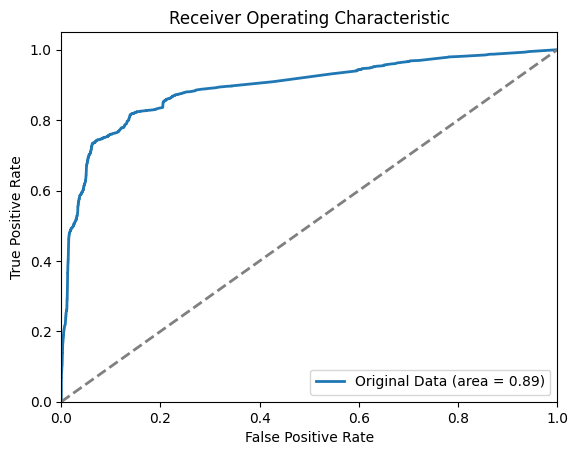

Nan Values are presnt in this Dataframe - Imputation started
Epoch [0/1000], Loss: 0.1369
Epoch [100/1000], Loss: 0.0727
Epoch [200/1000], Loss: 0.0422
Epoch [300/1000], Loss: 0.0259
Epoch [400/1000], Loss: 0.0164
Epoch [500/1000], Loss: 0.0107
Epoch [600/1000], Loss: 0.0071
Epoch [700/1000], Loss: 0.0047
Epoch [800/1000], Loss: 0.0030
Epoch [900/1000], Loss: 0.0019


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Nan Values are presnt in this Dataframe - Imputation started
Epoch [0/1000], Loss: 0.1761
Epoch [100/1000], Loss: 0.1230
Epoch [200/1000], Loss: 0.0904
Epoch [300/1000], Loss: 0.0694
Epoch [400/1000], Loss: 0.0547
Epoch [500/1000], Loss: 0.0435
Epoch [600/1000], Loss: 0.0347
Epoch [700/1000], Loss: 0.0276
Epoch [800/1000], Loss: 0.0218
Epoch [900/1000], Loss: 0.0170


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch [0/100], Loss: 0.2456
Accuracy: 0.9248689695018778
ROC AUC: 0.8880712114699392


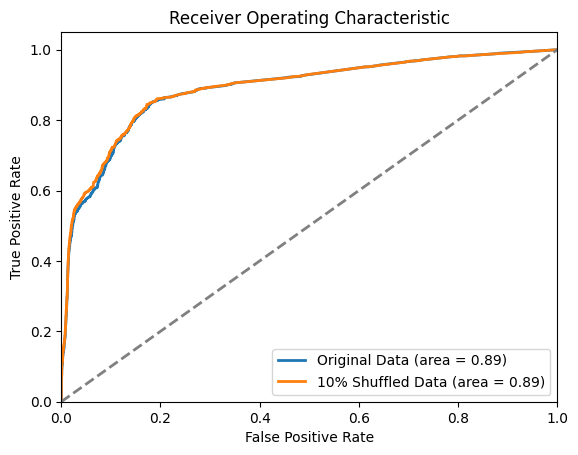

Nan Values are presnt in this Dataframe - Imputation started
Epoch [0/1000], Loss: 0.2320
Epoch [100/1000], Loss: 0.1551
Epoch [200/1000], Loss: 0.1139
Epoch [300/1000], Loss: 0.0890
Epoch [400/1000], Loss: 0.0714
Epoch [500/1000], Loss: 0.0579
Epoch [600/1000], Loss: 0.0471
Epoch [700/1000], Loss: 0.0383
Epoch [800/1000], Loss: 0.0311
Epoch [900/1000], Loss: 0.0252


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Nan Values are presnt in this Dataframe - Imputation started
Epoch [0/1000], Loss: 0.2303
Epoch [100/1000], Loss: 0.1230
Epoch [200/1000], Loss: 0.0787
Epoch [300/1000], Loss: 0.0572
Epoch [400/1000], Loss: 0.0438
Epoch [500/1000], Loss: 0.0341
Epoch [600/1000], Loss: 0.0267
Epoch [700/1000], Loss: 0.0208
Epoch [800/1000], Loss: 0.0160
Epoch [900/1000], Loss: 0.0122


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch [0/100], Loss: 0.1875
Accuracy: 0.9248689695018778
ROC AUC: 0.9013242709819984


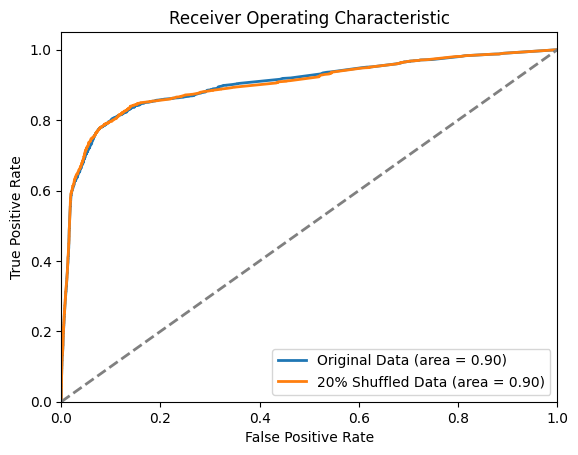

In [ ]:
# Call the function for different scenarios
fpr_original, tpr_original,preds_orignal = interpretation(train_data, test_data, train_labels, test_labels, model_type, feature_importance_type,model_name)
fpr_10_percent, tpr_10_percent,preds_10_percent = interpretation(train_data, test_data, train_labels, test_labels, model_type, feature_importance_type,model_name, shuffle_percent=0.1)
fpr_20_percent, tpr_20_percent,preds_20_percent = interpretation(train_data, test_data, train_labels, test_labels, model_type, feature_importance_type,model_name, shuffle_percent=0.2)

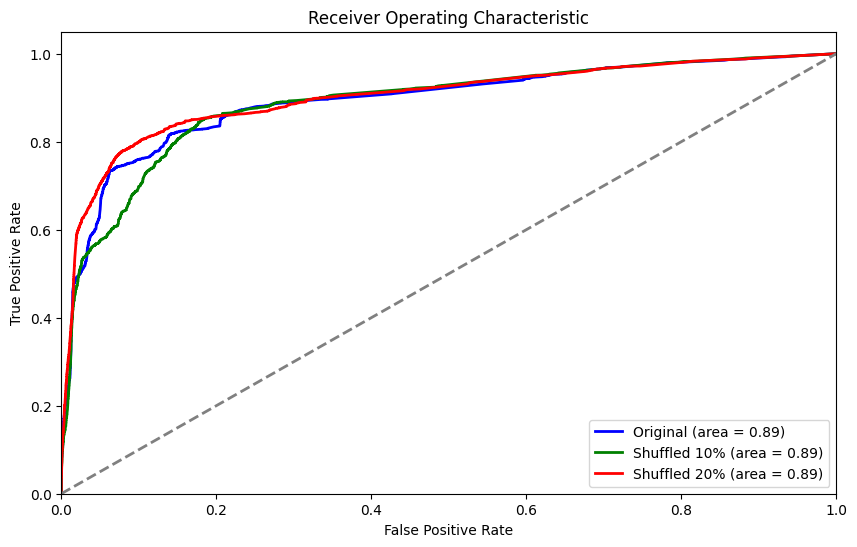

In [ ]:
# Plot all ROC curves on the same plot
plt.figure(figsize=(10, 6))
plt.plot(fpr_original, tpr_original, color='blue', lw=2, label='Original (area = {:.2f})'.format(roc_auc_score(test_labels, preds_orignal)))
plt.plot(fpr_10_percent, tpr_10_percent, color='green', lw=2, label='Shuffled 10% (area = {:.2f})'.format(roc_auc_score(test_labels, preds_10_percent)))
plt.plot(fpr_20_percent, tpr_20_percent, color='red', lw=2, label='Shuffled 20% (area = {:.2f})'.format(roc_auc_score(test_labels, preds_10_percent)))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import plotly.graph_objects as go

# Create traces
trace_original = go.Scatter(x=fpr_original, y=tpr_original, mode='lines', name='Original (area = {:.2f})'.format(roc_auc_score(test_labels, preds_orignal)), line=dict(width=3))
trace_10_percent = go.Scatter(x=fpr_10_percent, y=tpr_10_percent, mode='lines', name='Shuffled 10% (area = {:.2f})'.format(roc_auc_score(test_labels, preds_10_percent)), line=dict(width=3))
trace_20_percent = go.Scatter(x=fpr_20_percent, y=tpr_20_percent, mode='lines', name='Shuffled 20% (area = {:.2f})'.format(roc_auc_score(test_labels, preds_20_percent)), line=dict(width=3))
line_gray = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Guess', line=dict(color='gray', dash='dash', width=2))

data = [trace_original, trace_10_percent, trace_20_percent, line_gray]

# Layout settings
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    legend=dict(x=0.98, y=0.02),  # Bottom right corner
    margin=dict(l=50, r=20, t=50, b=50),
    width=800,
    height=500
)

# Create figure
fig = go.Figure(data=data, layout=layout)

# Show plot
fig.show()


BLOOD Samples


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
def train_and_evaluate_neural_network(train_data, test_data, train_labels, test_labels, hidden_dim1,hidden_dim2,hidden_dim3, num_runs=5000, learning_rate=0.001, num_epochs=100, plot_roc_auc=False):
    input_size = train_data.shape[1]  # Determine input size based on number of features

    # Convert DataFrame to PyTorch tensors
    X_train = torch.tensor(train_data.values, dtype=torch.float32)
    y_train = torch.tensor(train_labels.values, dtype=torch.float32)
    X_test = torch.tensor(test_data.values, dtype=torch.float32)
    y_test = torch.tensor(test_labels.values, dtype=torch.float32)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    run_performance = []
    models = []  # List to store models

    for run in range(num_runs):
        model = ComplexLGBMModel(input_size, hidden_dim1, hidden_dim2,hidden_dim3)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

        models.append(model)  # Store the trained model for this run

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            mse_criterion = nn.MSELoss()
            mse_loss = mse_criterion(val_outputs, y_val)
            run_performance.append(mse_loss.item())


        if (run + 1) % 100 == 0:
            print(f'Completed {run + 1} runs')

    best_run_idx = np.argmin(run_performance)
    best_model = models[best_run_idx]  # Load the best model based on the index
    best_model.eval()

    print("Best model selected.")

    best_model.eval()
    with torch.no_grad():
        test_outputs = best_model(X_test)
        test_loss = np.mean(np.square(test_outputs - y_test))
        print("Test Loss:", test_loss)

        if plot_roc_auc:
            fpr, tpr, _ = roc_curve(y_test, test_outputs)
            roc_auc = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()



In [ ]:
train_data = pd.read_csv('./Data/train_blood.csv')
test_data = pd.read_csv('./Data/test_blood.csv')
train_labels = pd.read_csv('./Data/y_train_blood.csv')
test_labels = pd.read_csv('./Data/y_test_blood.csv')


New network



In [490]:
class ImprovedModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, dropout_prob=0.15):
        super(ImprovedModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn3 = nn.BatchNorm1d(hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim2)
        self.fc5 = nn.Linear(hidden_dim2, 1)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))
        return x


Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 13178.4502
Epoch [100/1000], Loss: 45.6040
Epoch [200/1000], Loss: 12.5198
Epoch [300/1000], Loss: 5.3838
Epoch [400/1000], Loss: 3.0873
Epoch [500/1000], Loss: 2.1019
Epoch [600/1000], Loss: 1.6839
Epoch [700/1000], Loss: 1.4601
Epoch [800/1000], Loss: 1.2744
Epoch [900/1000], Loss: 1.1459
Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 11805.3359
Epoch [100/1000], Loss: 36.8229
Epoch [200/1000], Loss: 9.7216
Epoch [300/1000], Loss: 4.6905
Epoch [400/1000], Loss: 2.2327
Epoch [500/1000], Loss: 1.5297
Epoch [600/1000], Loss: 1.2072
Epoch [700/1000], Loss: 1.0616
Epoch [800/1000], Loss: 1.1107
Epoch [900/1000], Loss: 0.7933
Started Model Training and Optimzation
Epoch [0/1000], Loss: 0.2560
Epoch [100/1000], Loss: 0.2203
Epoch [200/1000], Loss: 0.2085
Epoch [300/1000], Loss: 0.2050
Epoch [400/1000], Loss: 0.2122
Epoch [500/1000], Loss: 0.2013
Epoch [600/1000], Loss: 0.

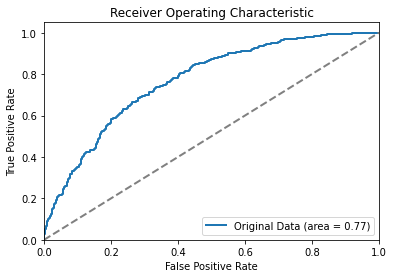

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.72762646e-04,
        9.72762646e-04, 1.94552529e-03, 1.94552529e-03, 2.91828794e-03,
        2.91828794e-03, 3.89105058e-03, 3.89105058e-03, 5.83657588e-03,
        5.83657588e-03, 6.80933852e-03, 6.80933852e-03, 7.78210117e-03,
        7.78210117e-03, 8.75486381e-03, 8.75486381e-03, 9.72762646e-03,
        9.72762646e-03, 1.07003891e-02, 1.07003891e-02, 1.16731518e-02,
        1.16731518e-02, 1.55642023e-02, 1.55642023e-02, 1.84824903e-02,
        1.84824903e-02, 2.04280156e-02, 2.04280156e-02, 2.14007782e-02,
        2.14007782e-02, 2.23735409e-02, 2.23735409e-02, 2.33463035e-02,
        2.33463035e-02, 2.43190661e-02, 2.43190661e-02, 2.62645914e-02,
        2.62645914e-02, 2.82101167e-02, 2.82101167e-02, 3.01556420e-02,
        3.01556420e-02, 3.11284047e-02, 3.11284047e-02, 3.40466926e-02,
        3.40466926e-02, 3.50194553e-02, 3.50194553e-02, 3.59922179e-02,
        3.59922179e-02, 3.69649805e-02, 3.69649805e-02, 3.793774

In [ ]:
model_type = "lgbm_blood"
feature_importance_type = "..."
model_name="Blood_model"
interpretation(train_data, test_data, train_labels, test_labels, model_type, feature_importance_type,model_name, shuffle_percent=None)

Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 13102.3164
Epoch [100/1000], Loss: 47.6617
Epoch [200/1000], Loss: 14.1691
Epoch [300/1000], Loss: 6.0164
Epoch [400/1000], Loss: 3.0682
Epoch [500/1000], Loss: 1.9865
Epoch [600/1000], Loss: 1.5575
Epoch [700/1000], Loss: 1.2858
Epoch [800/1000], Loss: 1.0833
Epoch [900/1000], Loss: 0.9517
Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 12137.1279
Epoch [100/1000], Loss: 35.3622
Epoch [200/1000], Loss: 9.6337
Epoch [300/1000], Loss: 4.1853
Epoch [400/1000], Loss: 2.1231
Epoch [500/1000], Loss: 1.4187
Epoch [600/1000], Loss: 1.1163
Epoch [700/1000], Loss: 1.0251
Epoch [800/1000], Loss: 0.7851
Epoch [900/1000], Loss: 0.6642
Started Model Training and Optimzation
Epoch [0/1000], Loss: 0.2663
Epoch [100/1000], Loss: 0.2269
Epoch [200/1000], Loss: 0.2106
Epoch [300/1000], Loss: 0.2043
Epoch [400/1000], Loss: 0.1881
Epoch [500/1000], Loss: 0.2018
Epoch [600/1000], Loss: 0.

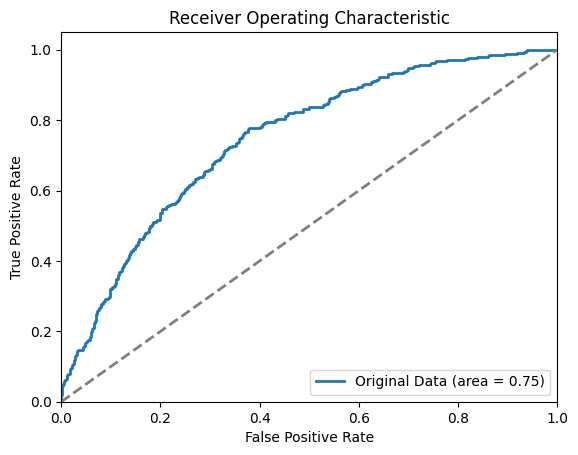

Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 13177.0977
Epoch [100/1000], Loss: 41.2170
Epoch [200/1000], Loss: 10.5697
Epoch [300/1000], Loss: 5.2704
Epoch [400/1000], Loss: 3.3288
Epoch [500/1000], Loss: 2.4281
Epoch [600/1000], Loss: 1.8283
Epoch [700/1000], Loss: 1.4022
Epoch [800/1000], Loss: 1.1570
Epoch [900/1000], Loss: 1.1364
Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 11633.9766
Epoch [100/1000], Loss: 32.1122
Epoch [200/1000], Loss: 9.0344
Epoch [300/1000], Loss: 5.3956
Epoch [400/1000], Loss: 3.4139
Epoch [500/1000], Loss: 2.0539
Epoch [600/1000], Loss: 1.3604
Epoch [700/1000], Loss: 1.0558
Epoch [800/1000], Loss: 1.0645
Epoch [900/1000], Loss: 1.0512
Started Model Training and Optimzation
Epoch [0/1000], Loss: 0.2402
Epoch [100/1000], Loss: 0.2187
Epoch [200/1000], Loss: 0.2126
Epoch [300/1000], Loss: 0.2159
Epoch [400/1000], Loss: 0.2201
Epoch [500/1000], Loss: 0.2167
Epoch [600/1000], Loss: 0.

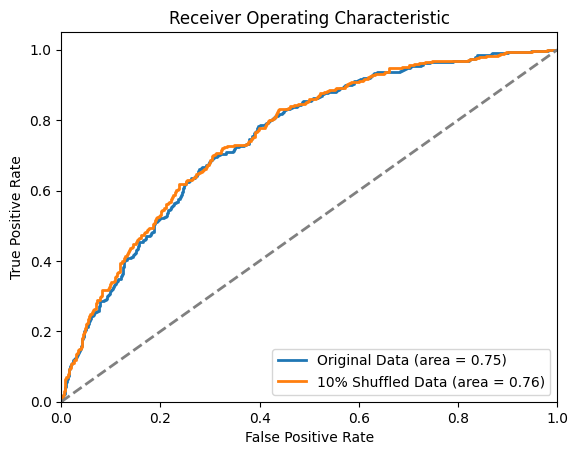

Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 13558.9375
Epoch [100/1000], Loss: 36.0298
Epoch [200/1000], Loss: 7.1413
Epoch [300/1000], Loss: 3.5992
Epoch [400/1000], Loss: 2.1486
Epoch [500/1000], Loss: 1.6470
Epoch [600/1000], Loss: 1.6223
Epoch [700/1000], Loss: 1.1058
Epoch [800/1000], Loss: 0.8918
Epoch [900/1000], Loss: 0.9079
Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 11692.4990
Epoch [100/1000], Loss: 34.1054
Epoch [200/1000], Loss: 9.2477
Epoch [300/1000], Loss: 5.0315
Epoch [400/1000], Loss: 2.9899
Epoch [500/1000], Loss: 2.0785
Epoch [600/1000], Loss: 1.5447
Epoch [700/1000], Loss: 1.3331
Epoch [800/1000], Loss: 0.9269
Epoch [900/1000], Loss: 0.7805
Started Model Training and Optimzation
Epoch [0/1000], Loss: 0.2576
Epoch [100/1000], Loss: 0.2174
Epoch [200/1000], Loss: 0.2077
Epoch [300/1000], Loss: 0.1992
Epoch [400/1000], Loss: 0.1937
Epoch [500/1000], Loss: 0.2045
Epoch [600/1000], Loss: 0.1

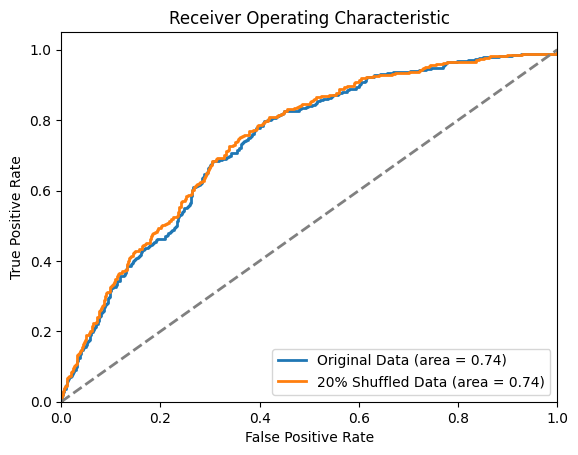

In [ ]:
fpr_original, tpr_original,preds_orignal = interpretation(train_data, test_data, train_labels, test_labels, model_type, feature_importance_type)
fpr_10_percent, tpr_10_percent,preds_10_percent = interpretation(train_data, test_data, train_labels, test_labels, model_type, feature_importance_type, shuffle_percent=0.1)
fpr_20_percent, tpr_20_percent,preds_20_percent = interpretation(train_data, test_data, train_labels, test_labels, model_type, feature_importance_type, shuffle_percent=0.2)

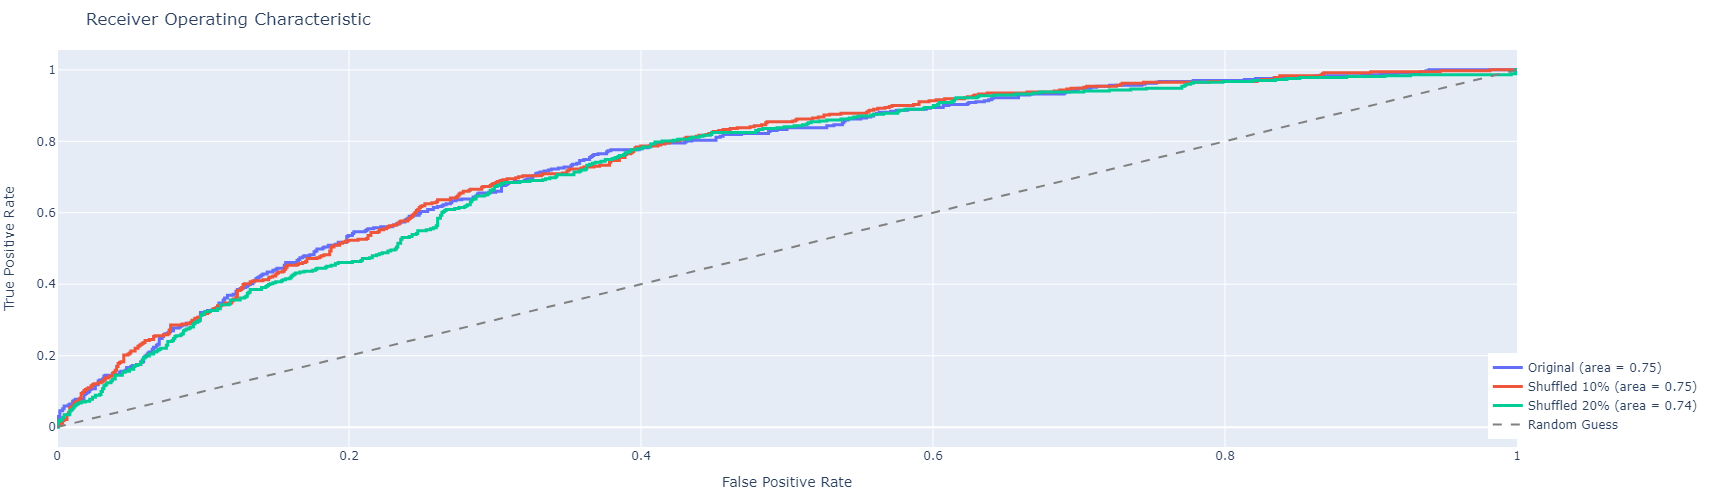

In [ ]:
import plotly.graph_objects as go

# Create traces
trace_original = go.Scatter(x=fpr_original, y=tpr_original, mode='lines', name='Original (area = {:.2f})'.format(roc_auc_score(test_labels, preds_orignal)), line=dict(width=3))
trace_10_percent = go.Scatter(x=fpr_10_percent, y=tpr_10_percent, mode='lines', name='Shuffled 10% (area = {:.2f})'.format(roc_auc_score(test_labels, preds_10_percent)), line=dict(width=3))
trace_20_percent = go.Scatter(x=fpr_20_percent, y=tpr_20_percent, mode='lines', name='Shuffled 20% (area = {:.2f})'.format(roc_auc_score(test_labels, preds_20_percent)), line=dict(width=3))
line_gray = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Guess', line=dict(color='gray', dash='dash', width=2))

data = [trace_original, trace_10_percent, trace_20_percent, line_gray]

# Layout settings
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    legend=dict(x=0.98, y=0.02),  # Bottom right corner
    margin=dict(l=50, r=20, t=50, b=50),
    width=800,
    height=500
)

# Create figure
fig = go.Figure(data=data, layout=layout)

# Show plot
fig.show()

Permutation Sesitivity Analysis

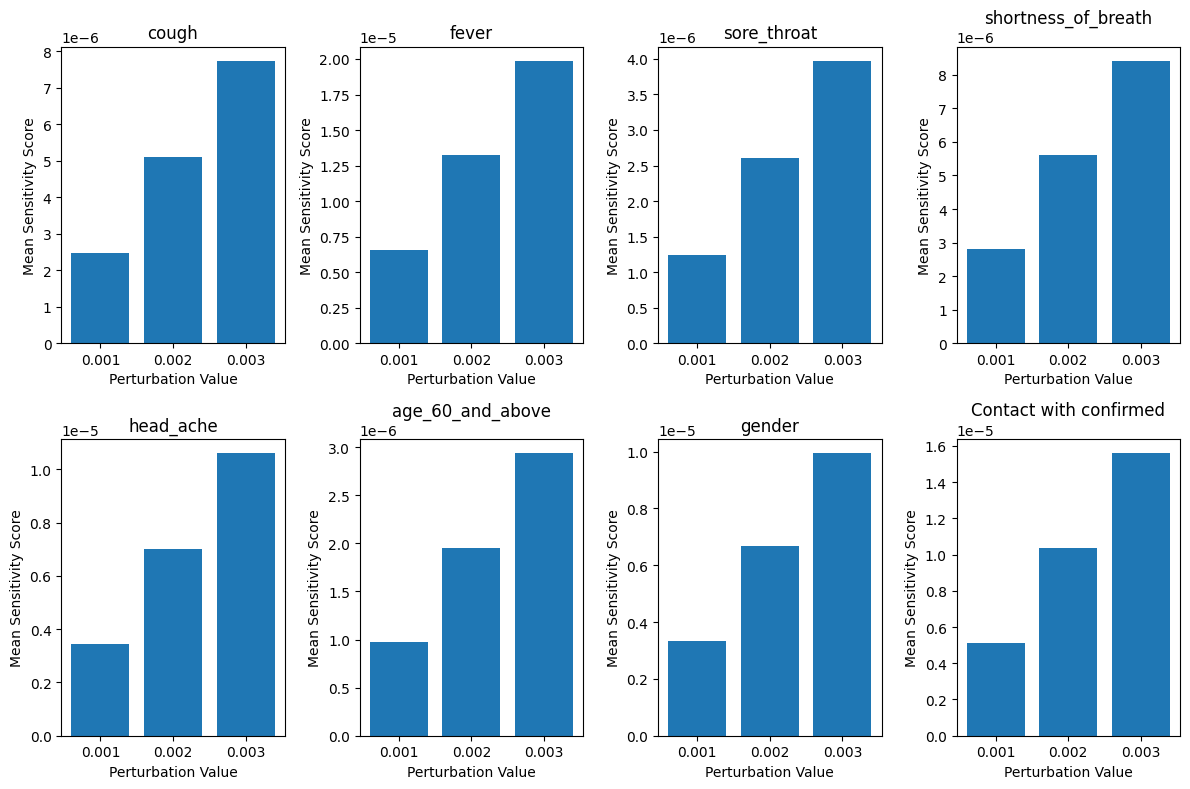

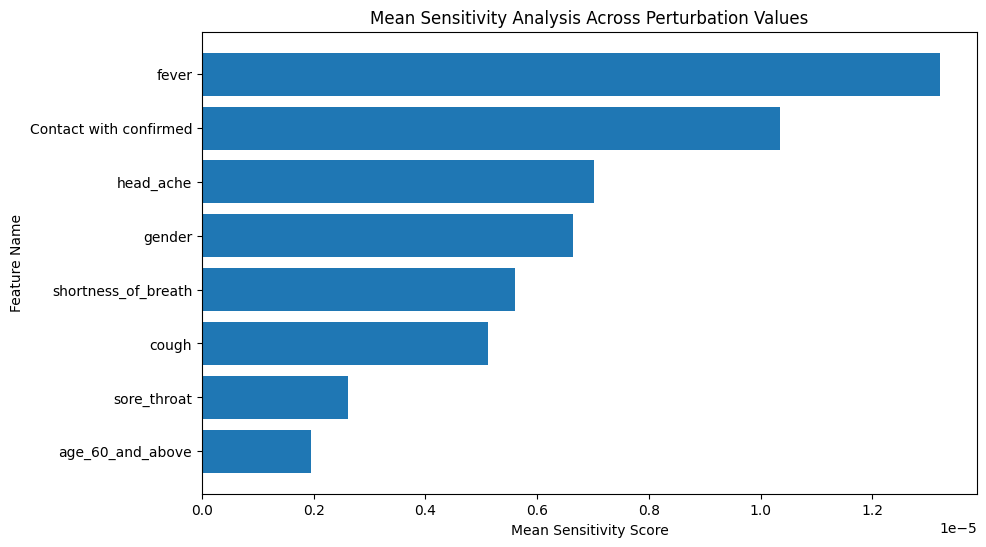

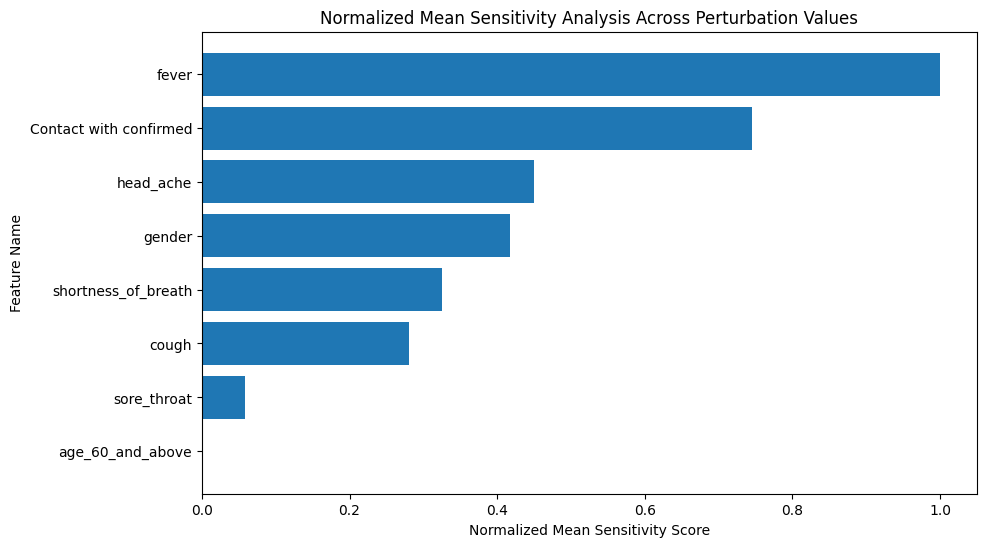

In [35]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Choose an input data point for sensitivity analysis
train_data = pd.read_csv('/content/drive/MyDrive/Deep learning/Project/Data/train_data.csv')
input_data = torch.tensor(train_data.values, dtype=torch.float32)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(input_data)
feat_num=X_normalized.shape[1]
# Load your pre-trained model
model = ComplexLGBMModel(input_dim=feat_num, hidden_dim1=256, hidden_dim2=64,hidden_dim3=16)  # Instantiate your model class
model.load_state_dict(torch.load('/content/drive/MyDrive/Deep learning/Project/Covid_model.pth'))  # Load the model's state_dict
model.eval()


batch_size = 32  # Choose an appropriate batch size
total_samples = input_data.size(0)
num_batches = total_samples // batch_size

# Initialize an array to store sensitivity scores
all_sensitivity_scores = []

# Calculate baseline predictions for the original input data
baseline_predictions = []

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size

    batch_data = input_data[start_idx:end_idx]
    batch_predictions = model(batch_data)

    baseline_predictions.append(batch_predictions)

baseline_predictions = torch.cat(baseline_predictions)

# Iterate over each feature
for feature_idx in range(input_data.size(1)):  # Iterating over features
    sensitivity_scores = []

    # Perturb the current feature with different perturbation values
    for perturbation in [0.001, 0.002, 0.003]:  # Adjust perturbation values as needed
        perturbed_data = input_data.clone()
        perturbed_data[:, feature_idx] += perturbation

        perturbed_predictions = []
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size

            batch_data = perturbed_data[start_idx:end_idx]
            batch_predictions = model(batch_data)

            perturbed_predictions.append(batch_predictions)

        perturbed_predictions = torch.cat(perturbed_predictions)

        # Calculate sensitivity score (change in prediction)
        sensitivity = torch.abs(perturbed_predictions - baseline_predictions)
        sensitivity_scores.append(sensitivity.mean().item())

    all_sensitivity_scores.append(sensitivity_scores)

# Convert sensitivity_scores list to a NumPy array
all_sensitivity_scores = np.array(all_sensitivity_scores)

# Create a bar plot for each feature's sensitivity analysis
feature_names = train_data.columns
plt.figure(figsize=(12, 8))
for feature_idx in range(input_data.size(1)):
    plt.subplot(2, 4, feature_idx + 1)  # Adjust subplot arrangement based on the number of features
    plt.bar(['0.001', '0.002', '0.003'], all_sensitivity_scores[feature_idx])
    plt.title('{}'.format(feature_names[feature_idx]))
    plt.xlabel('Perturbation Value')
    plt.ylabel('Mean Sensitivity Score')

plt.tight_layout()
plt.show()

# Calculate the mean sensitivity score across perturbation values for each feature
mean_sensitivity_across_perturbations = all_sensitivity_scores.mean(axis=1)
# Sort features by descending mean sensitivity scores
# Sort features by descending mean sensitivity scores
sorted_indices = np.argsort(mean_sensitivity_across_perturbations)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_mean_sensitivity = mean_sensitivity_across_perturbations[sorted_indices]
# Create a bar plot to show the mean sensitivity scores for each feature
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_mean_sensitivity)
plt.xlabel('Mean Sensitivity Score')
plt.ylabel('Feature Name')
plt.title('Mean Sensitivity Analysis Across Perturbation Values')
plt.gca().invert_yaxis()
plt.show()


# Normalize the mean sensitivity scores using Min-Max scaling
scaler = MinMaxScaler()
normalized_sensitivity_scores = scaler.fit_transform(sorted_mean_sensitivity.reshape(-1, 1)).flatten()

# Create a bar plot to show the normalized mean sensitivity scores for each feature
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, normalized_sensitivity_scores)
plt.xlabel('Normalized Mean Sensitivity Score')
plt.ylabel('Feature Name')
plt.title('Normalized Mean Sensitivity Analysis Across Perturbation Values')
plt.gca().invert_yaxis()  # Invert the y-axis to have highest sensitivity at the top
plt.show()

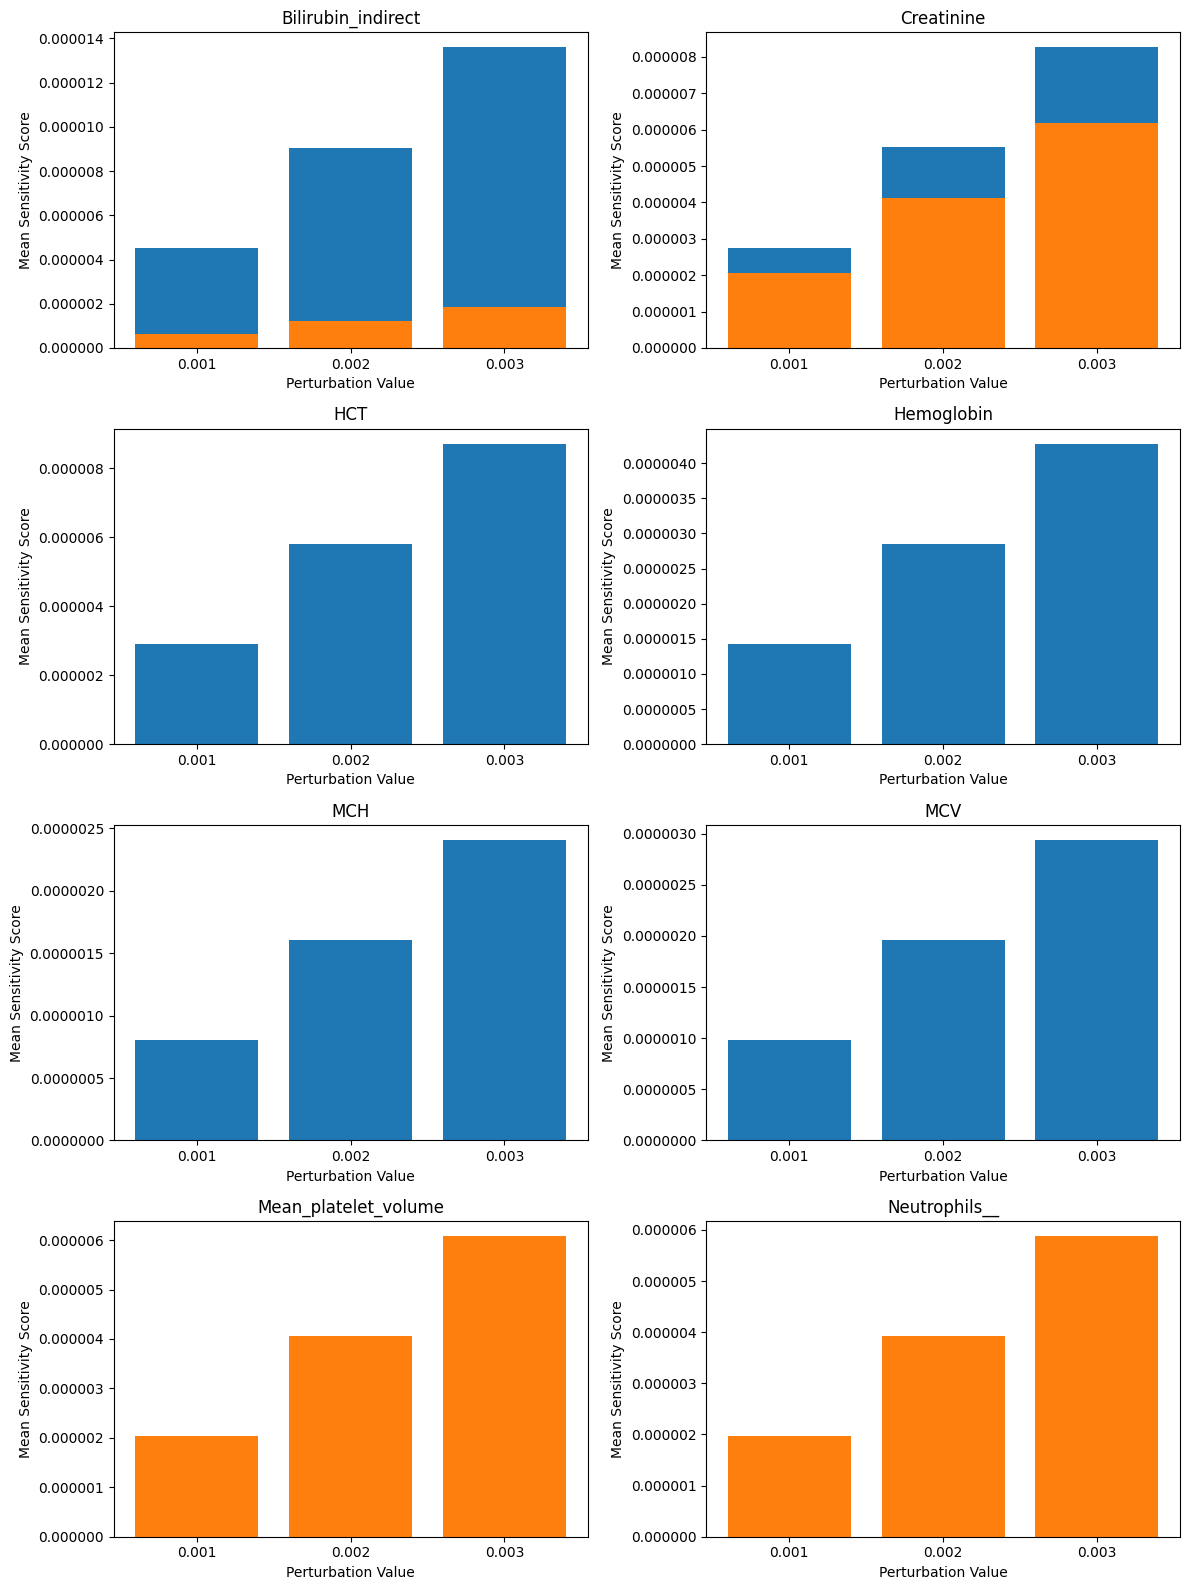

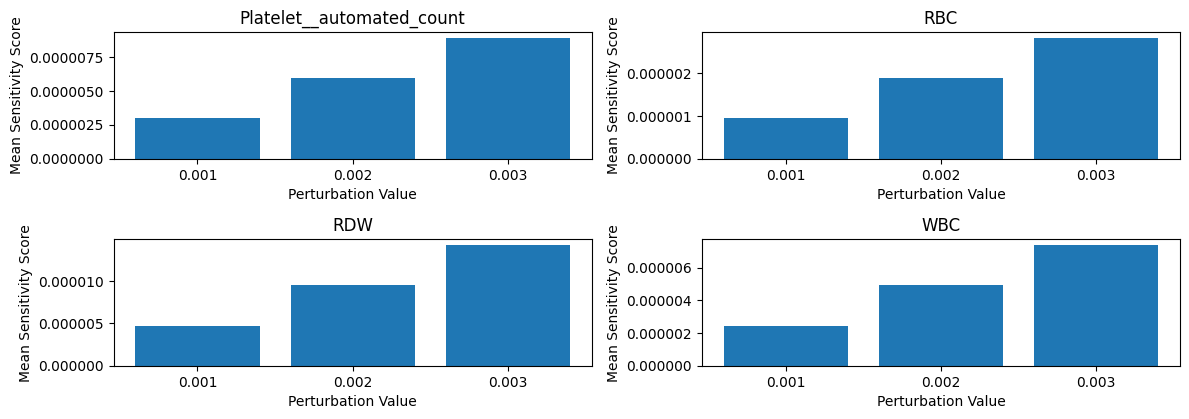

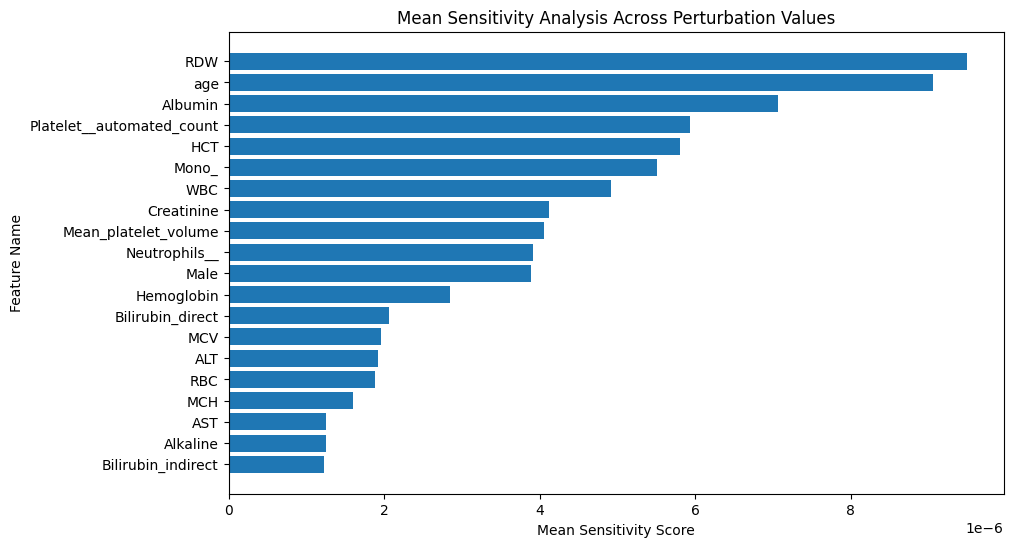

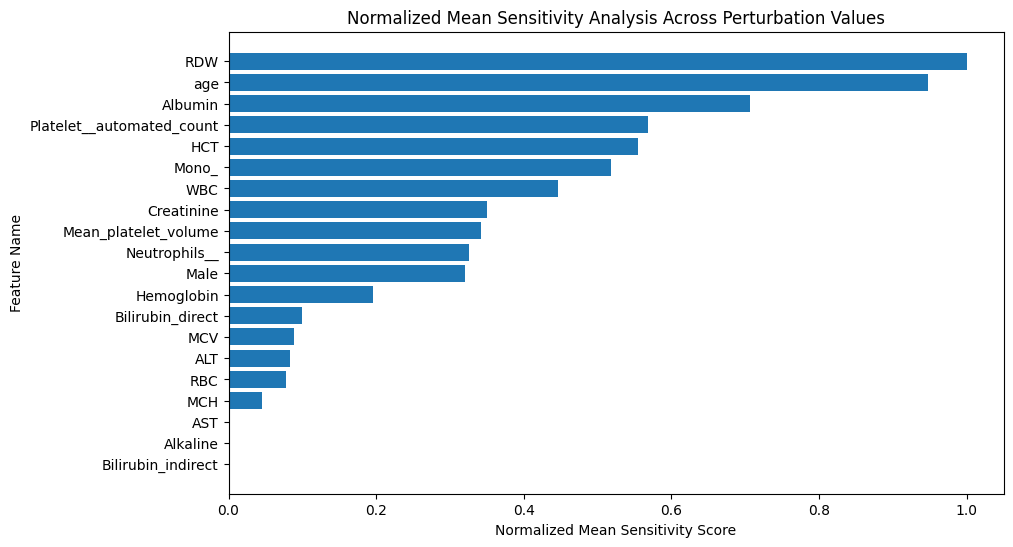

In [139]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Choose an input data point for sensitivity analysis
train_data = pd.read_csv('./Data/train_blood.csv')
input_data = torch.tensor(train_data.values, dtype=torch.float32)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(input_data)
feat_num=X_normalized.shape[1]
# Load your pre-trained model
model = ImprovedModel(input_dim=feat_num, hidden_dim1=256, hidden_dim2=64,hidden_dim3=16)  # Instantiate your model class
model.load_state_dict(torch.load('./Blood_model.pth'))  # Load the model's state_dict
model.eval()


batch_size = 32  # Choose an appropriate batch size
total_samples = input_data.size(0)
num_batches = total_samples // batch_size

# Initialize an array to store sensitivity scores
all_sensitivity_scores = []

# Calculate baseline predictions for the original input data
baseline_predictions = []

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size

    batch_data = input_data[start_idx:end_idx]
    batch_predictions = model(batch_data)

    baseline_predictions.append(batch_predictions)

baseline_predictions = torch.cat(baseline_predictions)

# Iterate over each feature
for feature_idx in range(input_data.size(1)):  # Iterating over features
    sensitivity_scores = []

    # Perturb the current feature with different perturbation values
    for perturbation in [0.001, 0.002, 0.003]:  # Adjust perturbation values as needed
        perturbed_data = input_data.clone()
        perturbed_data[:, feature_idx] += perturbation

        perturbed_predictions = []
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size

            batch_data = perturbed_data[start_idx:end_idx]
            batch_predictions = model(batch_data)

            perturbed_predictions.append(batch_predictions)

        perturbed_predictions = torch.cat(perturbed_predictions)

        # Calculate sensitivity score (change in prediction)
        sensitivity = torch.abs(perturbed_predictions - baseline_predictions)
        sensitivity_scores.append(sensitivity.mean().item())

    all_sensitivity_scores.append(sensitivity_scores)

# Convert sensitivity_scores list to a NumPy array
all_sensitivity_scores = np.array(all_sensitivity_scores)
#############################################################################################

# Create a bar plot for each feature's sensitivity analysis
feature_names = train_data.columns
num_features = len(feature_names)
num_rows = 4  # Number of rows in the subplot grid
num_cols = 2  # Number of columns in the subplot grid
features_per_plot = num_rows * num_cols

# Create the first and second plots
plt.figure(figsize=(12, 16))  # Adjust figsize based on your preference

for plot_num in range(2):
    plt.subplot(3, 1, plot_num + 1)  # Create 2 rows of subplots
    start_idx = plot_num * features_per_plot
    end_idx = start_idx + features_per_plot
    for feature_idx in range(start_idx, min(end_idx, num_features)):
        plt.subplot(num_rows, num_cols, feature_idx - start_idx + 1)
        plt.bar(['0.001', '0.002', '0.003'], all_sensitivity_scores[feature_idx])
        plt.title('{}'.format(feature_names[feature_idx]))
        plt.xlabel('Perturbation Value')
        plt.ylabel('Mean Sensitivity Score')
        
        # Format y-axis tick labels without scientific notation
        plt.gca().yaxis.get_major_formatter().set_scientific(False)
        plt.gca().yaxis.get_major_formatter().set_useOffset(False)

plt.tight_layout()

# Save the first and second plots to files (e.g., PNG format)
plt.savefig('sensitivity_analysis_plot_1.png', dpi=300)  # You can adjust the DPI (resolution) as needed

# Show the first and second plots (optional)
plt.show()

# Create the third plot for remaining features
if num_features > features_per_plot * 2:
    plt.figure(figsize=(12, 8))

    for feature_idx in range(features_per_plot * 2, num_features):
        plt.subplot(num_rows, num_cols, feature_idx - features_per_plot * 2 + 1)
        plt.bar(['0.001', '0.002', '0.003'], all_sensitivity_scores[feature_idx])
        plt.title('{}'.format(feature_names[feature_idx]))
        plt.xlabel('Perturbation Value')
        plt.ylabel('Mean Sensitivity Score')
        
        # Format y-axis tick labels without scientific notation
        plt.gca().yaxis.get_major_formatter().set_scientific(False)
        plt.gca().yaxis.get_major_formatter().set_useOffset(False)

    plt.tight_layout()

    # Save the third plot to a file (e.g., PNG format)
    plt.savefig('sensitivity_analysis_plot_3.png', dpi=300)  # You can adjust the DPI (resolution) as needed

    # Show the third plot (optional)
    plt.show()

#############################################################################################3
# Calculate the mean sensitivity score across perturbation values for each feature
mean_sensitivity_across_perturbations = all_sensitivity_scores.mean(axis=1)
# Sort features by descending mean sensitivity scores
# Sort features by descending mean sensitivity scores
sorted_indices = np.argsort(mean_sensitivity_across_perturbations)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_mean_sensitivity = mean_sensitivity_across_perturbations[sorted_indices]
# Create a bar plot to show the mean sensitivity scores for each feature
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_mean_sensitivity)
plt.xlabel('Mean Sensitivity Score')
plt.ylabel('Feature Name')
plt.title('Mean Sensitivity Analysis Across Perturbation Values')
plt.gca().invert_yaxis()
plt.show()


# Normalize the mean sensitivity scores using Min-Max scaling
scaler = MinMaxScaler()
normalized_sensitivity_scores = scaler.fit_transform(sorted_mean_sensitivity.reshape(-1, 1)).flatten()

# Create a bar plot to show the normalized mean sensitivity scores for each feature
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, normalized_sensitivity_scores)
plt.xlabel('Normalized Mean Sensitivity Score')
plt.ylabel('Feature Name')
plt.title('Normalized Mean Sensitivity Analysis Across Perturbation Values')
plt.gca().invert_yaxis()  # Invert the y-axis to have highest sensitivity at the top
plt.show()

Sensitvity Analysis Function

In [491]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import json

def sensitivity_analysis(train_data, model):
    input_data = torch.tensor(train_data.values, dtype=torch.float32)
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(input_data)
    feat_num = X_normalized.shape[1]

    batch_size = 32  # Choose an appropriate batch size
    total_samples = input_data.size(0)
    num_batches = total_samples // batch_size

    # Initialize an array to store sensitivity scores
    all_sensitivity_scores = []

    # Calculate baseline predictions for the original input data
    baseline_predictions = []

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size

        batch_data = input_data[start_idx:end_idx]
        batch_predictions = model(batch_data)

        baseline_predictions.append(batch_predictions)

    baseline_predictions = torch.cat(baseline_predictions)

    # Iterate over each feature
    for feature_idx in range(input_data.size(1)):
        sensitivity_scores = []

        # Perturb the current feature with different perturbation values
        for perturbation in [0.001, 0.002, 0.003]:  # Adjust perturbation values as needed
            perturbed_data = input_data.clone()
            perturbed_data[:, feature_idx] += perturbation

            perturbed_predictions = []
            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = start_idx + batch_size

                batch_data = perturbed_data[start_idx:end_idx]
                batch_predictions = model(batch_data)

                perturbed_predictions.append(batch_predictions)

            perturbed_predictions = torch.cat(perturbed_predictions)

            # Calculate sensitivity score (change in prediction)
            sensitivity = torch.abs(perturbed_predictions - baseline_predictions)
            sensitivity_scores.append(sensitivity.mean().item())

        all_sensitivity_scores.append(sensitivity_scores)

    # Convert sensitivity_scores list to a NumPy array
    all_sensitivity_scores = np.array(all_sensitivity_scores)

    # Calculate the mean sensitivity score across perturbation values for each feature
    mean_sensitivity_across_perturbations = all_sensitivity_scores.mean(axis=1)

    # Sort features by descending mean sensitivity scores
    sorted_indices = np.argsort(mean_sensitivity_across_perturbations)[::-1]
    sorted_feature_names = train_data.columns[sorted_indices]
    sorted_mean_sensitivity = mean_sensitivity_across_perturbations[sorted_indices]

    # Normalize the mean sensitivity scores using Min-Max scaling
    scaler = MinMaxScaler()
    normalized_sensitivity_scores = scaler.fit_transform(sorted_mean_sensitivity.reshape(-1, 1)).flatten()

    # Create and show the final plot
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_feature_names, normalized_sensitivity_scores)
    plt.xlabel('Normalized Mean Sensitivity Score')
    plt.ylabel('Feature Name')
    plt.title('Normalized Mean Sensitivity Analysis Across Perturbation Values')
    plt.gca().invert_yaxis()  # Invert the y-axis to have highest sensitivity at the top
    plt.show()

    # Create JSON representation of normalized sensitivity scores
    normalized_scores_json = json.dumps(dict(zip(sorted_feature_names, normalized_sensitivity_scores)), indent=4)

    return normalized_scores_json

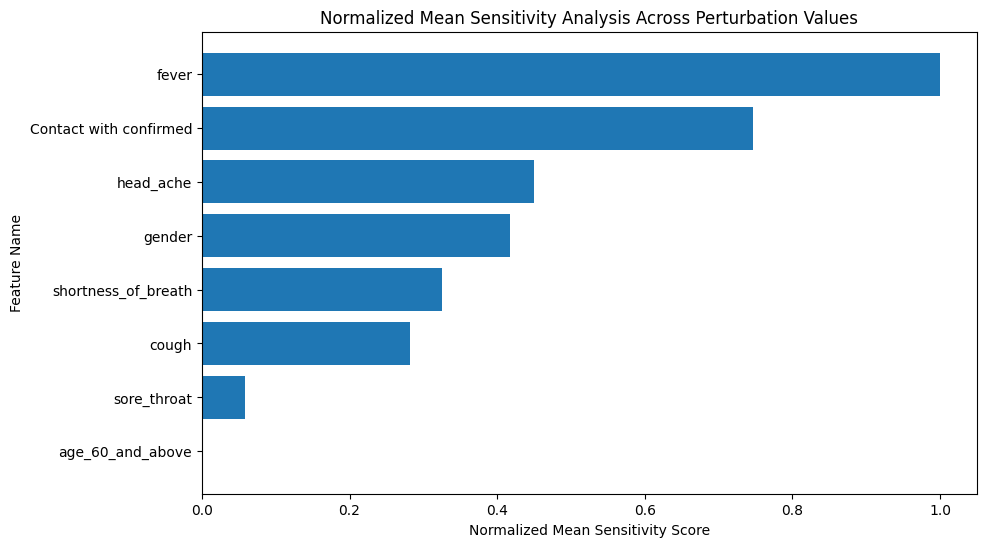

{
    "fever": 1.0,
    "Contact with confirmed": 0.746362374675337,
    "head_ache": 0.4502967438605523,
    "gender": 0.4168491543790137,
    "shortness_of_breath": 0.3255699005068773,
    "cough": 0.281370420841936,
    "sore_throat": 0.05858697915740205,
    "age_60_and_above": 0.0
}


In [492]:
# Load train data
train_data = pd.read_csv('./Data/train_data.csv')
input_data = torch.tensor(train_data.values, dtype=torch.float32)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(input_data)
feat_num=X_normalized.shape[1]

model = ComplexLGBMModel(input_dim=feat_num, hidden_dim1=256, hidden_dim2=64, hidden_dim3=16)
model.load_state_dict(torch.load('./Covid_model.pth'))
model.eval()

# Call the sensitivity analysis function with train data and model
sesntivity_covid = sensitivity_analysis(train_data, model)

# Print the JSON representation of normalized sensitivity scores
print(sesntivity_covid)

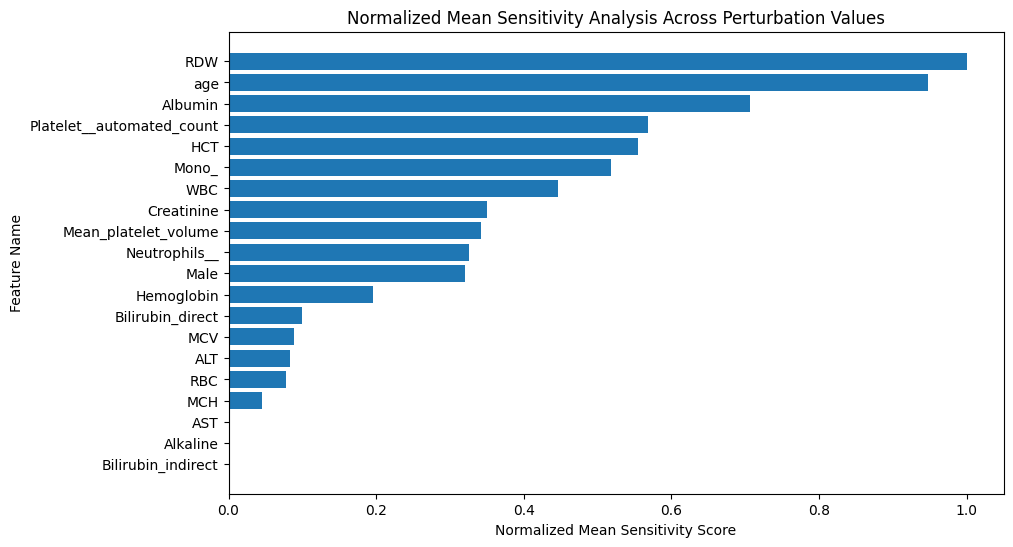

{
    "RDW": 0.9999999999999999,
    "age": 0.9478416793648242,
    "Albumin": 0.7069226044806076,
    "Platelet__automated_count": 0.5686077538044161,
    "HCT": 0.5541857632283032,
    "Mono_": 0.5180321454424748,
    "WBC": 0.4466273373187961,
    "Creatinine": 0.34967960558658556,
    "Mean_platelet_volume": 0.34178428768445135,
    "Neutrophils__": 0.3253077692113335,
    "Male": 0.3210407441064825,
    "Hemoglobin": 0.19608118279094772,
    "Bilirubin_direct": 0.09987268760078472,
    "MCV": 0.08844350609902957,
    "ALT": 0.08365347722030503,
    "RBC": 0.07843940710100039,
    "MCH": 0.04532497560602003,
    "AST": 0.001994188190306445,
    "Alkaline": 0.0018950214733738924,
    "Bilirubin_indirect": 0.0
}


In [493]:
train_data = pd.read_csv('./Data/train_blood.csv')
input_data = torch.tensor(train_data.values, dtype=torch.float32)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(input_data)
feat_num=X_normalized.shape[1]

model = ImprovedModel(input_dim=feat_num, hidden_dim1=256, hidden_dim2=64, hidden_dim3=16)
model.load_state_dict(torch.load('./Blood_model.pth'))
model.eval()

# Call the sensitivity analysis function with train data and model
sesetvity_blood = sensitivity_analysis(train_data, model)

# Print the JSON representation of normalized sensitivity scores
print(sesetvity_blood)

Grad-Feature Importance


In [72]:
train_data = pd.read_csv('./Data/train_data.csv')
input_data = torch.tensor(train_data.values, dtype=torch.float32)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(input_data)
feat_num=X_normalized.shape[1]
# Convert normalized numpy array to PyTorch tensor
X_normalized_tensor = torch.tensor(X_normalized)

####
input_data = X_normalized_tensor.clone().detach().requires_grad_(True)
######

# Load your pre-trained model weights
model = ComplexLGBMModel(input_dim=feat_num, hidden_dim1=256, hidden_dim2=64, hidden_dim3=16)
model.load_state_dict(torch.load('./Covid_model.pth'))
model.eval

<bound method Module.eval of ComplexLGBMModel(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)>

Input Data Type: torch.float32
After NaN Handling: torch.float32
After fc1 and ReLU: torch.float32
After fc2 and ReLU: torch.float32
After fc3 and ReLU: torch.float32
After fc4 and ReLU: torch.float32
Output Data Type: torch.float32


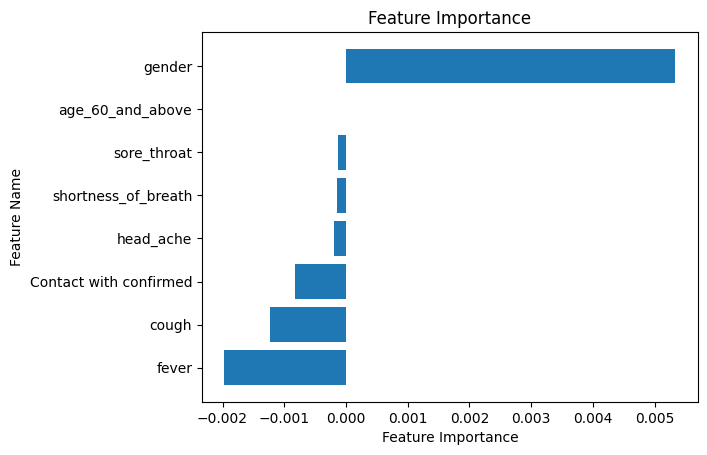

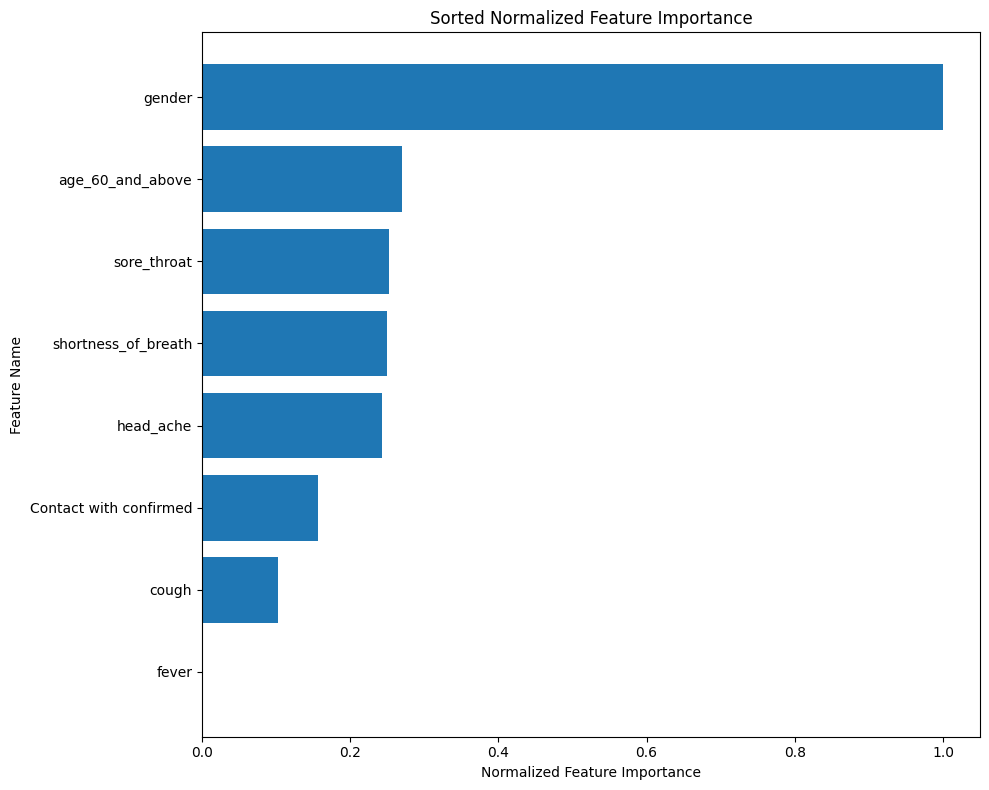

In [172]:
train_data = pd.read_csv('./Data/train_data.csv')
input_data = torch.tensor(train_data.values, dtype=torch.float32)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(input_data)
feat_num=X_normalized.shape[1]
# Convert normalized numpy array to PyTorch tensor
X_normalized_tensor = torch.tensor(X_normalized)

####
input_data = X_normalized_tensor.clone().detach().requires_grad_(True)
######

# Load your pre-trained model weights
model = ComplexLGBMModel(input_dim=feat_num, hidden_dim1=256, hidden_dim2=64, hidden_dim3=16)
model.load_state_dict(torch.load('./Covid_model.pth'))
model.eval
# Forward pass
X_normalized_tensor = X_normalized_tensor.type_as(model.fc1.weight)
X_normalized_tensor = torch.where(torch.isnan(X_normalized_tensor), torch.zeros_like(X_normalized_tensor), X_normalized_tensor)
# Perform the forward pass
input_data = X_normalized_tensor.clone().detach().requires_grad_(True)
output = model(input_data)
# Select a specific output neuron (e.g., 0 for binary classification)
selected_neuron = 0

# Calculate the gradient of the selected output neuron with respect to the input data
output[selected_neuron].backward()

# Calculate the feature importance scores by multiplying the gradient with the input data
feature_importance = torch.abs(input_data.grad) * input_data

# Sum the feature importance scores along the batch dimension
feature_importance_sum = torch.sum(feature_importance, dim=0)
feature_importance_sum_np = feature_importance_sum.detach().cpu().numpy()
sorted_indices = np.argsort(feature_importance_sum_np)[::-1]
sorted_feature_names = np.array(train_data.columns)[sorted_indices]
sorted_importance = feature_importance_sum_np[sorted_indices]

# Create a bar plot for feature importance
plt.barh(sorted_feature_names, sorted_importance.tolist())
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.gca().invert_yaxis() 
plt.show()



# Normalize feature importance scores to [0, 1]
min_importance = torch.min(feature_importance_sum)
max_importance = torch.max(feature_importance_sum)
normalized_importance = (feature_importance_sum - min_importance) / (max_importance - min_importance)

# Convert normalized_importance to a NumPy array for sorting
normalized_importance_np = normalized_importance.detach().cpu().numpy()

sorted_indices = np.argsort(normalized_importance_np)[::-1]
sorted_feature_names = np.array(train_data.columns)[sorted_indices]
sorted_importance = normalized_importance_np[sorted_indices]

# Create a bar plot for sorted normalized feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_importance.tolist())
plt.xlabel('Normalized Feature Importance')
plt.ylabel('Feature Name')
plt.title('Sorted Normalized Feature Importance')
plt.tight_layout()
plt.gca().invert_yaxis()  
plt.show()







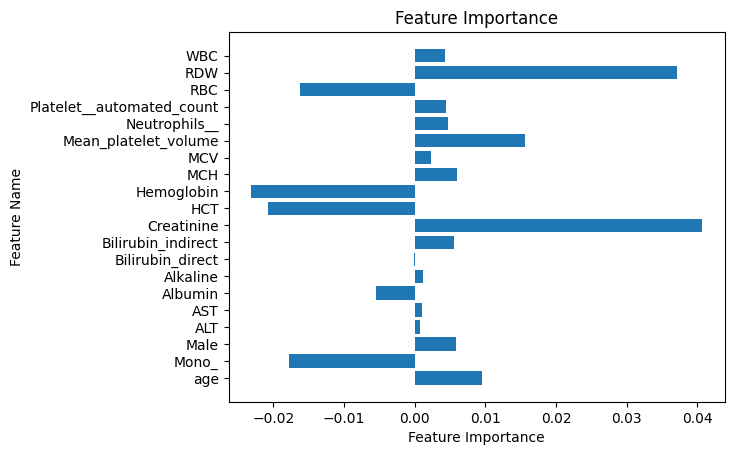

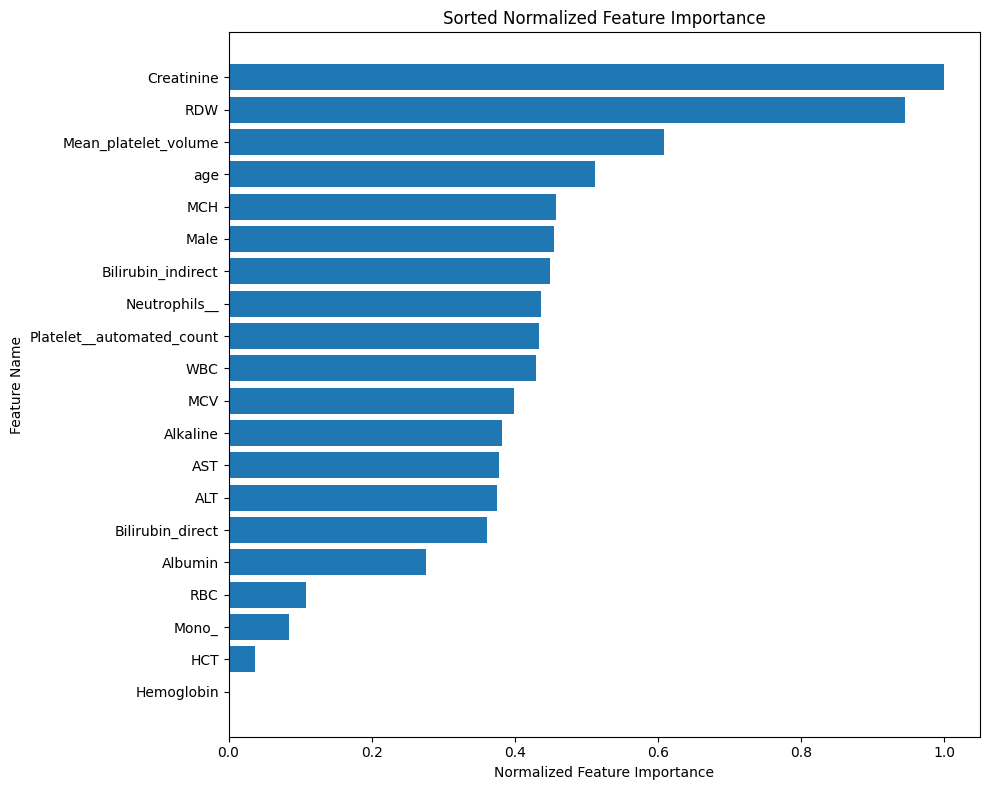

In [184]:
train_data = pd.read_csv('./Data/train_blood.csv')
input_data = torch.tensor(train_data.values, dtype=torch.float32)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(input_data)
feat_num=X_normalized.shape[1]
# Convert normalized numpy array to PyTorch tensor
X_normalized_tensor = torch.tensor(X_normalized)

####
input_data = X_normalized_tensor.clone().detach().requires_grad_(True)
######

# Load your pre-trained model weights
model = ImprovedModel(input_dim=feat_num, hidden_dim1=256, hidden_dim2=64, hidden_dim3=16)
model.load_state_dict(torch.load('./Blood_model.pth'))
model.eval
# Forward pass
X_normalized_tensor = X_normalized_tensor.type_as(model.fc1.weight)
X_normalized_tensor = torch.where(torch.isnan(X_normalized_tensor), torch.zeros_like(X_normalized_tensor), X_normalized_tensor)
# Perform the forward pass
input_data = X_normalized_tensor.clone().detach().requires_grad_(True)
output = model(input_data)
# Select a specific output neuron (e.g., 0 for binary classification)
selected_neuron = 0

# Calculate the gradient of the selected output neuron with respect to the input data
output[selected_neuron].backward()

# Calculate the feature importance scores by multiplying the gradient with the input data
feature_importance = torch.abs(input_data.grad) * input_data

# Sum the feature importance scores along the batch dimension
feature_importance_sum = torch.sum(feature_importance, dim=0)

# Create a bar plot for feature importance
plt.barh(feature_names, feature_importance_sum.tolist())
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.show()

# Normalize feature importance scores to [0, 1]
min_importance = torch.min(feature_importance_sum)
max_importance = torch.max(feature_importance_sum)
normalized_importance = (feature_importance_sum - min_importance) / (max_importance - min_importance)

# Convert normalized_importance to a NumPy array for sorting
normalized_importance_np = normalized_importance.detach().cpu().numpy()

sorted_indices = np.argsort(normalized_importance_np)[::-1]
sorted_feature_names = np.array(train_data.columns)[sorted_indices]
sorted_importance = normalized_importance_np[sorted_indices]

# Create a bar plot for sorted normalized feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_importance.tolist())
plt.xlabel('Normalized Feature Importance')
plt.ylabel('Feature Name')
plt.title('Sorted Normalized Feature Importance')
plt.tight_layout()
plt.gca().invert_yaxis()  
plt.show()


Gradiant Feature Importance Function 

In [496]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import json

def Gradiant_importnace(model, train_data):
    feature_names = train_data.columns
    num_features = len(feature_names)
    input_data = torch.tensor(train_data.values, dtype=torch.float32)
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(input_data)
    feat_num=X_normalized.shape[1]
    # Convert normalized numpy array to PyTorch tensor
    X_normalized_tensor = torch.tensor(X_normalized)

    ####
    # Forward pass
    X_normalized_tensor = X_normalized_tensor.type_as(model.fc1.weight)
    X_normalized_tensor = torch.where(torch.isnan(X_normalized_tensor), torch.zeros_like(X_normalized_tensor), X_normalized_tensor)
    # Perform the forward pass
    input_data = X_normalized_tensor.clone().detach().requires_grad_(True)
    
    # Forward pass through the model
    output = model(input_data)
    
    # Select a specific output neuron (e.g., 0 for binary classification)
    selected_neuron = 0
    
    # Calculate the gradient of the selected output neuron with respect to the input data
    output[selected_neuron].backward()
    
    # Calculate the feature importance scores by multiplying the gradient with the input data
    feature_importance = torch.abs(input_data.grad) * input_data
    
    # Sum the feature importance scores along the batch dimension
    feature_importance_sum = torch.sum(feature_importance, dim=0)
    
    # Normalize feature importance scores to [0, 1]
    min_importance = torch.min(feature_importance_sum)
    max_importance = torch.max(feature_importance_sum)
    normalized_importance = (feature_importance_sum - min_importance) / (max_importance - min_importance)
    
    # Convert normalized_importance to a NumPy array for sorting
    normalized_importance_np = normalized_importance.detach().cpu().numpy()
    
    sorted_indices = np.argsort(normalized_importance_np)[::-1]
    sorted_feature_names = np.array(train_data.columns)[sorted_indices]
    sorted_importance = normalized_importance_np[sorted_indices]
    
    # Create a bar plot for sorted normalized feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(sorted_feature_names, sorted_importance.tolist())
    plt.xlabel('Normalized Feature Importance')
    plt.ylabel('Feature Name')
    plt.title('Sorted Normalized Feature Importance')
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plot_filename = 'sorted_normalized_feature_importance.png'
    plt.savefig(plot_filename, dpi=300)  # Save the plot to a file
    plt.show()
    
    # Create a dictionary of feature names and their importance values
    importance_dict = {feature: float(importance) for feature, importance in zip(sorted_feature_names, sorted_importance)}
    
    # Save the importance dictionary as JSON
    importance_json_filename = 'feature_importance.json'
    with open(importance_json_filename, 'w') as json_file:
        json.dump(importance_dict, json_file)
    
    return importance_dict, plot_filename


Feature importance: {'RDW': 1.0, 'WBC': 0.5098987817764282, 'Platelet__automated_count': 0.4894745945930481, 'Creatinine': 0.4650605022907257, 'age': 0.42067351937294006, 'Mean_platelet_volume': 0.4201069474220276, 'Neutrophils__': 0.40211358666419983, 'Bilirubin_indirect': 0.3999800980091095, 'Male': 0.39413294196128845, 'Alkaline': 0.38582706451416016, 'AST': 0.38472864031791687, 'MCV': 0.3793407678604126, 'MCH': 0.36118996143341064, 'Bilirubin_direct': 0.34959954023361206, 'ALT': 0.32804444432258606, 'Albumin': 0.28679174184799194, 'Hemoglobin': 0.2457309365272522, 'RBC': 0.21119922399520874, 'HCT': 0.20910820364952087, 'Mono_': 0.0}
Plot saved as: sorted_normalized_feature_importance.png


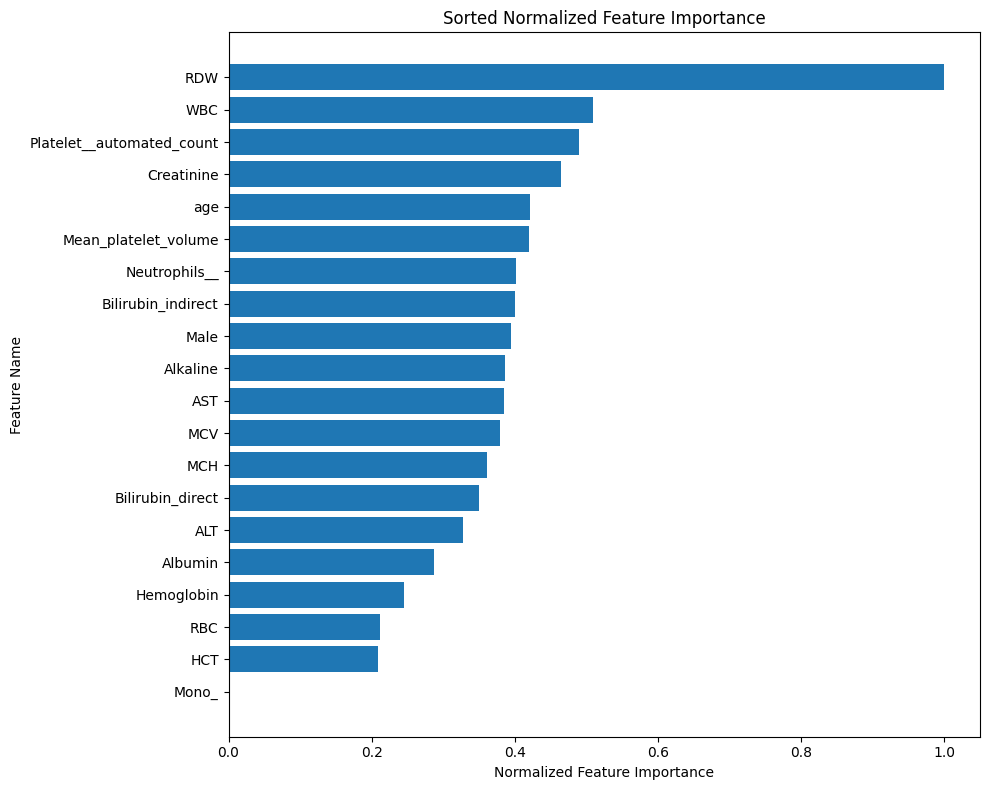

In [495]:
train_data = pd.read_csv('./Data/train_blood.csv')
input_data = torch.tensor(train_data.values, dtype=torch.float32)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(input_data)
feat_num=X_normalized.shape[1]
# Convert normalized numpy array to PyTorch tensor
X_normalized_tensor = torch.tensor(X_normalized)

####
input_data = X_normalized_tensor.clone().detach().requires_grad_(True)
######

# Load your pre-trained model weights
model = ImprovedModel(input_dim=feat_num, hidden_dim1=256, hidden_dim2=64, hidden_dim3=16)
model.load_state_dict(torch.load('./Blood_model.pth'))
model.eval

Gradiant_blood, plot_filename = Gradiant_importnace(model, train_data)
print("Feature importance:", Gradiant_blood)
print("Plot saved as:", plot_filename)

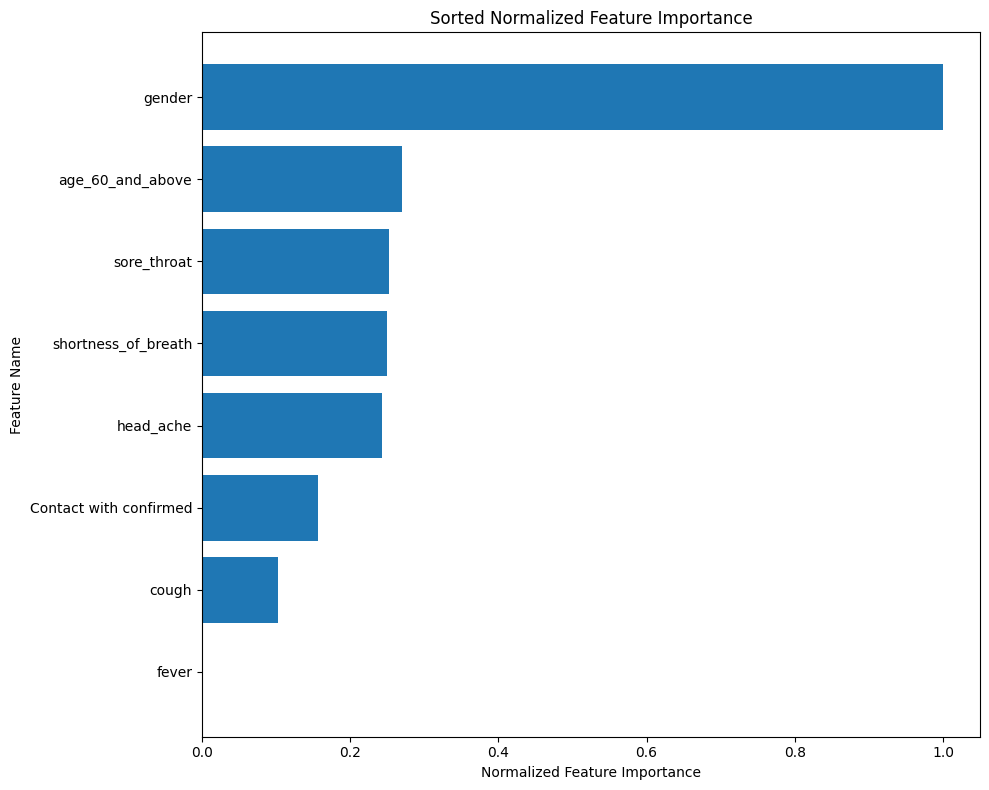

Feature importance: {'gender': 1.0, 'age_60_and_above': 0.2695627212524414, 'sore_throat': 0.25290316343307495, 'shortness_of_breath': 0.2496519237756729, 'head_ache': 0.24248826503753662, 'Contact with confirmed': 0.15731842815876007, 'cough': 0.1020435020327568, 'fever': 0.0}


In [498]:
train_data = pd.read_csv('./Data/train_data.csv')
input_data = torch.tensor(train_data.values, dtype=torch.float32)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(input_data)
feat_num=X_normalized.shape[1]
# Convert normalized numpy array to PyTorch tensor
X_normalized_tensor = torch.tensor(X_normalized)

####
input_data = X_normalized_tensor.clone().detach().requires_grad_(True)
######

# Load your pre-trained model weights
model = ComplexLGBMModel(input_dim=feat_num, hidden_dim1=256, hidden_dim2=64, hidden_dim3=16)
model.load_state_dict(torch.load('./Covid_model.pth'))
model.eval

Gradiant_covid, plot_filename = Gradiant_importnace(model, train_data)
print("Feature importance:", Gradiant_covid)


In [333]:
train_data = pd.read_csv('./Data/train_data.csv')
train_labels=pd.read_csv('./Data/train_labels.csv')
input_data = torch.tensor(train_data.values, dtype=torch.float32)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(input_data)
feat_num=X_normalized.shape[1]
X_normalized_tensor = torch.tensor(X_normalized)

model = ComplexLGBMModel(input_dim=feat_num, hidden_dim1=256, hidden_dim2=64, hidden_dim3=16)
model.load_state_dict(torch.load('./Covid_model.pth'))
model.eval()

ComplexLGBMModel(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [491]:
train_data = pd.read_csv('./Data/train_blood.csv')
input_data = torch.tensor(train_data.values, dtype=torch.float32)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(input_data)
feat_num=X_normalized.shape[1]

model = ImprovedModel(input_dim=feat_num, hidden_dim1=256, hidden_dim2=64, hidden_dim3=16)
model.load_state_dict(torch.load('./Blood_model.pth'))
model.eval()

ImprovedModel(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=16, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.15, inplace=False)
  (sigmoid): Sigmoid()
)

Activation Maximisation


In [647]:
import numpy as np
import shap

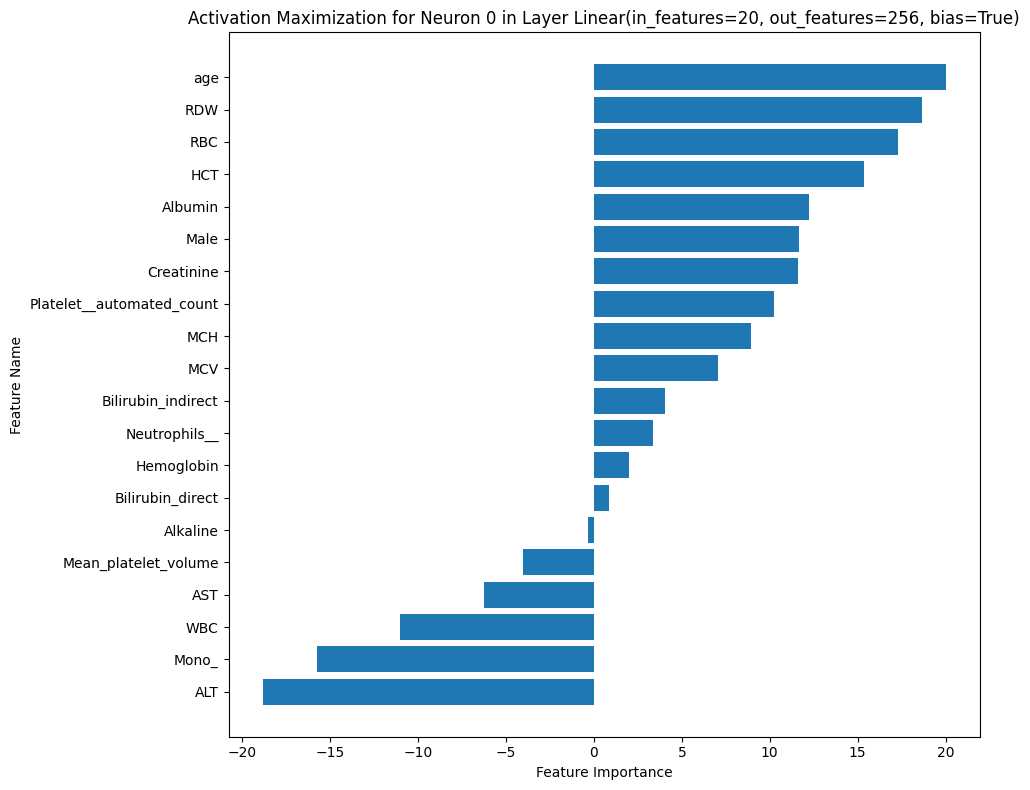

In [784]:
train_data = pd.read_csv('./Data/train_blood.csv')
input_data = torch.tensor(train_data.values, dtype=torch.float32)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(input_data)
feat_num=X_normalized.shape[1]
X_normalized_tensor = torch.tensor(X_normalized)
 ####
# Forward pass
X_normalized_tensor = X_normalized_tensor.type_as(model.fc1.weight)
X_normalized_tensor = torch.where(torch.isnan(X_normalized_tensor), torch.zeros_like(X_normalized_tensor), X_normalized_tensor)


# Load your deep learning model (replace with your own model loading code)
model = ImprovedModel(input_dim=feat_num, hidden_dim1=256, hidden_dim2=64, hidden_dim3=16)
model.load_state_dict(torch.load('./Blood_model.pth'))



# Choose the layer and neuron you want to maximize activation for
target_layer = model.fc1   # Replace with the index of the layer you want to analyze
target_neuron = 0  # Replace with the index of the neuron in the target layer

# Create input data point
input_data = X_normalized_tensor.clone().detach().requires_grad_(True)  # Adjust the input shape to match your model's input size

# Set up the loss function to maximize the target neuron's activation
criterion = nn.MSELoss()
optimizer = optim.SGD([input_data], lr=0.1)  # You can adjust the learning rate

# Number of optimization iterations
num_iterations = 1000

# Optimization loop
for i in range(num_iterations):
    # Forward pass
    output = target_layer(input_data)

    # Compute the loss as the negative activation of the target neuron
    loss = -output[0][target_neuron]  # Access the specific neuron in the output

    # Backpropagation and optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

# Extract the optimized values from the input_data tensor
optimized_values = input_data.detach().numpy()[0]
sorted_indices = np.argsort(optimized_values)[::-1]
sorted_feature_names = np.array(train_data.columns)[sorted_indices]
sorted_importance = optimized_values[sorted_indices]
# Visualize the optimized input data
# Create a bar plot for sorted normalized feature importance
plt.figure(figsize=(10, 8))
plt.title(f"Activation Maximization for Neuron {target_neuron} in Layer {target_layer}")
plt.barh(sorted_feature_names, sorted_importance.tolist())
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

In [785]:
# Iterate through the model's layers and print the number of neurons in each layer
for name, layer in model.named_children():
    if isinstance(layer, (nn.Linear, nn.Sigmoid)):
        num_neurons = layer.out_features if isinstance(layer, nn.Linear) else None
        activation_function = "Sigmoid" if isinstance(layer, nn.Sigmoid) else "ReLU"
        print(f"Layer: {name}, Number of Neurons: {num_neurons}, Activation Function: {activation_function}")

Layer: fc1, Number of Neurons: 256, Activation Function: ReLU
Layer: fc2, Number of Neurons: 64, Activation Function: ReLU
Layer: fc3, Number of Neurons: 16, Activation Function: ReLU
Layer: fc4, Number of Neurons: 64, Activation Function: ReLU
Layer: fc5, Number of Neurons: 1, Activation Function: ReLU
Layer: sigmoid, Number of Neurons: None, Activation Function: Sigmoid


Activation Maximization Funcation

In [251]:
# Define a function to perform activation maximization for a given layer and target neuron
def activation_maximization(model, layer_name, target_neuron, input_data, num_iterations=1000):
    # Choose the layer and neuron you want to maximize activation for
    target_layer = getattr(model, layer_name)  # Replace with the index of the layer you want to analyze
    target_neuron =  target_neuron # Replace with the index of the neuron in the target layer
    # Set up the loss function to maximize the target neuron's activation
    criterion = nn.MSELoss()
    optimizer = optim.SGD([input_data], lr=0.1)  # You can adjust the learning rate

    # Number of optimization iterations
    num_iterations = 1000

    # Optimization loop
    for i in range(num_iterations):
        # Forward pass
        output = target_layer(input_data)

        # Compute the loss as the negative activation of the target neuron
        loss = -output[0][target_neuron]  # Access the specific neuron in the output

        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # Extract the optimized values from the input_data tensor
    optimized_values = input_data.detach().numpy()[0]
    sorted_indices = np.argsort(optimized_values)[::-1]
    sorted_feature_names = np.array(train_data.columns)[sorted_indices]
    sorted_importance = optimized_values[sorted_indices]
    # Visualize the optimized input data
    # Create a bar plot for sorted normalized feature importance
    #plt.figure(figsize=(10, 8))
    #plt.title(f"Activation Maximization for Neuron {target_neuron} in Layer {target_layer}")
    #plt.barh(sorted_feature_names, sorted_importance.tolist())
    #plt.xlabel('Feature Importance')
    #plt.ylabel('Feature Name')
    #plt.tight_layout()
    #plt.gca().invert_yaxis()

    return sorted_importance


In [249]:
train_data = pd.read_csv('./Data/train_blood.csv')
input_data = torch.tensor(train_data.values, dtype=torch.float32)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(input_data)
feat_num=X_normalized.shape[1]
X_normalized_tensor = torch.tensor(X_normalized)
 ####
# Forward pass
X_normalized_tensor = X_normalized_tensor.type_as(model.fc1.weight)
X_normalized_tensor = torch.where(torch.isnan(X_normalized_tensor), torch.zeros_like(X_normalized_tensor), X_normalized_tensor)


# Load your deep learning model (replace with your own model loading code)
model = ImprovedModel(input_dim=feat_num, hidden_dim1=256, hidden_dim2=64, hidden_dim3=16)
model.load_state_dict(torch.load('./Blood_model.pth'))
# Create input data point
input_data = X_normalized_tensor.clone().detach().requires_grad_(True)  # Adjust the input shape to match your model's input size

layer_dict = {}  # Initialize an empty dictionary

for name, layer in model.named_children():
    if isinstance(layer, (nn.Linear, nn.Sigmoid)):
        num_neurons = layer.out_features if isinstance(layer, nn.Linear) else None
        activation_function = "Sigmoid" if isinstance(layer, nn.Sigmoid) else "ReLU"
        
        # Create a tuple with layer information and store it in the dictionary
        layer_info = (name, num_neurons, activation_function)
        layer_dict[name] = layer_info
        
        print(f"Layer: {name}, Number of Neurons: {num_neurons}, Activation Function: {activation_function}")


# Create lists to store layer names and neuron numbers
layer_names_list = []
neuron_numbers_list = []

# Iterate through the layers in layer_dict
for layer_name, (name, num_neurons, activation_function) in layer_dict.items():
    # Append layer name to the list
    layer_names_list.append(layer_name)
    
    # Append neuron number to the list (convert None to 0)
    neuron_numbers_list.append(num_neurons if num_neurons is not None else 0)

# Display the lists
print("Layer Names List:", layer_names_list)
print("Neuron Numbers List:", neuron_numbers_list)


Layer: fc1, Number of Neurons: 256, Activation Function: ReLU
Layer: fc2, Number of Neurons: 64, Activation Function: ReLU
Layer: fc3, Number of Neurons: 16, Activation Function: ReLU
Layer: fc4, Number of Neurons: 64, Activation Function: ReLU
Layer: fc5, Number of Neurons: 1, Activation Function: ReLU
Layer: sigmoid, Number of Neurons: None, Activation Function: Sigmoid
Layer Names List: ['fc1', 'fc2', 'fc3', 'fc4', 'fc5', 'sigmoid']
Neuron Numbers List: [256, 64, 16, 64, 1, 0]


Activation Maximzation Function

In [273]:
import pandas as pd
import scipy.stats

def analyze_feature_importance(model, train_data, input_data, num_iterations=1000):
    # Create a DataFrame to store the results for fc1 layer
    fc1_neuron_imp_df = pd.DataFrame(columns=train_data.columns)  # Initialize with empty columns

    # Get the number of neurons for the "fc1" layer (convert None to 0)
    num_neurons_fc1 = layer_dict.get("fc1", (None, 0))[1]

    # Loop over the neuron numbers in fc1 layer and call activation_maximization
    for target_neuron in range(num_neurons_fc1):
        print(f"Layer: fc1, Target Neuron: {target_neuron}")

        # Call activation_maximization function for the "fc1" layer and current neuron
        fc1_neuron_imp = activation_maximization(model, "fc1", target_neuron, input_data, num_iterations=num_iterations)

        # Add the feature importance to the DataFrame with neuron number as index
        fc1_neuron_imp_df.loc[f"fc1_neuron_{target_neuron}"] = fc1_neuron_imp

    # Display the DataFrame with neuron names as index and feature names as columns
    print("Feature Importance for fc1 Neurons:")
    print(fc1_neuron_imp_df)
    
    avrage_fc1_importance=fc1_neuron_imp_df.mean()
    avrage_fc1_importance

    min_value = avrage_fc1_importance.min()
    max_value = avrage_fc1_importance.max()

    # Min-Max scaling
    normalized_fc1_importance = (avrage_fc1_importance - min_value) / (max_value - min_value)
    
    # Call activation_maximization function for the "sigmoid" layer
    sig_neuron_imp = activation_maximization(model, "sigmoid", 0, input_data, num_iterations=num_iterations)

    # Create a DataFrame with the feature importance values
    sig_neuron_imp_df = pd.DataFrame([sig_neuron_imp], columns=train_data.columns)

    # Sort the columns by feature names
    sig_neuron_imp_df = sig_neuron_imp_df[train_data.columns]

    # Calculate the minimum and maximum values in the DataFrame
    min_value = sig_neuron_imp_df.min().min()
    max_value = sig_neuron_imp_df.max().max()

    # Perform min-max scaling to normalize between 0 and 1
    normalized_sig_neuron_imp_df = (sig_neuron_imp_df - min_value) / (max_value - min_value)

    # The 'normalized_sig_neuron_imp_df' DataFrame now contains normalized values between 0 and 1

    first_layer_list = normalized_sig_neuron_imp_df.iloc[0]

    # Convert it to a list if needed
    first_layer_list = first_layer_list.tolist()

    # Calculate the Spearman rank correlation coefficient
    #spearman_corr, _ = scipy.stats.spearmanr(normalized_fc1_importance, first_row_list)

    #print(f"Spearman Rank Correlation Coefficient: {spearman_corr}")

    # Create dictionaries to store the positions of features in both lists
    position_dict1 = {feature: position for position, feature in enumerate(normalized_fc1_importance)}
    position_dict2 = {feature: position for position, feature in enumerate(first_layer_list)}

    # Initialize lists to store information about position changes
    position_changes = []

    # Iterate through features in the first list
    for feature, position1 in position_dict1.items():
        position2 = position_dict2.get(feature, None)  # Get the position in the second list

        if position2 is not None and position1 != position2:
            # Feature changed position
            position_changes.append((feature, position1, position2))

    # Check if there are position changes and print accordingly
    if position_changes:
        for feature, position1, position2 in position_changes:
            print(f"Feature '{feature}' changed position from {position1} to {position2}")
    else:
        print("All features are in the same position.")
    import numpy as np
    import matplotlib.pyplot as plt

    # Assuming blood_sig and blood_fc1 are DataFrames with one row each
    sorted_indices = np.argsort(normalized_sig_neuron_imp_df.values[0])[::-1]
    sorted_feature_names = np.array(train_data.columns)[sorted_indices]
    # Calculate positions for the bars
    bar_width = 0.4  # Adjust this as needed
    bar_positions_fc1 = np.arange(len(sorted_feature_names))
    bar_positions_sig_layer = bar_positions_fc1 + bar_width

    plt.figure(figsize=(10, 8))

    plt.title(f"Activation Maximization Feature Importance")

    # Plot the FC Layer bars
    plt.barh(bar_positions_fc1, normalized_fc1_importance, bar_width, label='FC Layer', alpha=0.5, color='blue')

    # Plot the Sigmoid Layer bars
    plt.barh(bar_positions_sig_layer, normalized_sig_neuron_imp_df.values[0], bar_width, label='Sigmoid Layer', alpha=0.5, color='red')

    # Set the ticks and labels for y-axis
    plt.yticks(bar_positions_fc1 + bar_width / 2, sorted_feature_names)

    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()
    return normalized_fc1_importance,normalized_sig_neuron_imp_df

Layer: fc1, Target Neuron: 0
Layer: fc1, Target Neuron: 1
Layer: fc1, Target Neuron: 2
Layer: fc1, Target Neuron: 3
Layer: fc1, Target Neuron: 4
Layer: fc1, Target Neuron: 5
Layer: fc1, Target Neuron: 6
Layer: fc1, Target Neuron: 7
Layer: fc1, Target Neuron: 8
Layer: fc1, Target Neuron: 9
Layer: fc1, Target Neuron: 10
Layer: fc1, Target Neuron: 11
Layer: fc1, Target Neuron: 12
Layer: fc1, Target Neuron: 13
Layer: fc1, Target Neuron: 14
Layer: fc1, Target Neuron: 15
Layer: fc1, Target Neuron: 16
Layer: fc1, Target Neuron: 17
Layer: fc1, Target Neuron: 18
Layer: fc1, Target Neuron: 19
Layer: fc1, Target Neuron: 20
Layer: fc1, Target Neuron: 21
Layer: fc1, Target Neuron: 22
Layer: fc1, Target Neuron: 23
Layer: fc1, Target Neuron: 24
Layer: fc1, Target Neuron: 25
Layer: fc1, Target Neuron: 26
Layer: fc1, Target Neuron: 27
Layer: fc1, Target Neuron: 28
Layer: fc1, Target Neuron: 29
Layer: fc1, Target Neuron: 30
Layer: fc1, Target Neuron: 31
Layer: fc1, Target Neuron: 32
Layer: fc1, Target N

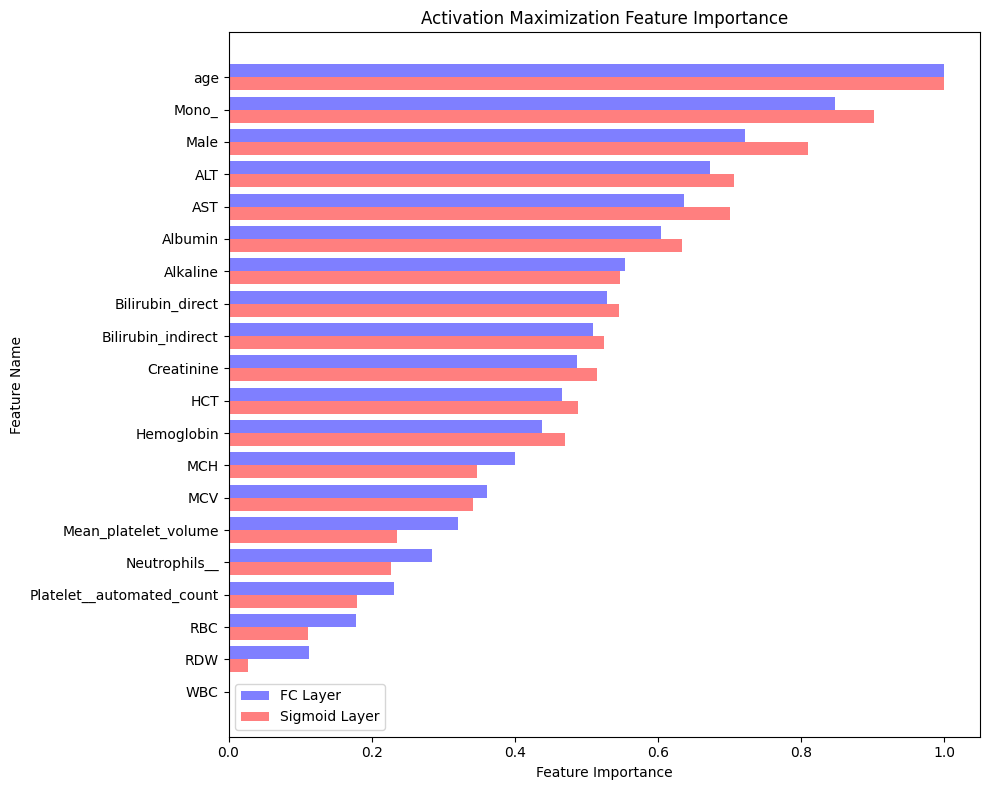

In [274]:
train_data = pd.read_csv('./Data/train_blood.csv')
input_data = torch.tensor(train_data.values, dtype=torch.float32)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(input_data)
feat_num=X_normalized.shape[1]
X_normalized_tensor = torch.tensor(X_normalized)
 ####
# Forward pass
X_normalized_tensor = X_normalized_tensor.type_as(model.fc1.weight)
X_normalized_tensor = torch.where(torch.isnan(X_normalized_tensor), torch.zeros_like(X_normalized_tensor), X_normalized_tensor)


# Load your deep learning model (replace with your own model loading code)
model = ImprovedModel(input_dim=feat_num, hidden_dim1=256, hidden_dim2=64, hidden_dim3=16)
model.load_state_dict(torch.load('./Blood_model.pth'))
# Create input data point
input_data = X_normalized_tensor.clone().detach().requires_grad_(True)  # Adjust the input shape to match your model's input size

blood_fc1,blood_sig=analyze_feature_importance(model, train_data, input_data, num_iterations=1000)

In [478]:
blood_sig.columns[:3]

Index(['age', 'Mono_', 'Male'], dtype='object')

Layer: fc1, Target Neuron: 0
Layer: fc1, Target Neuron: 1
Layer: fc1, Target Neuron: 2
Layer: fc1, Target Neuron: 3
Layer: fc1, Target Neuron: 4
Layer: fc1, Target Neuron: 5
Layer: fc1, Target Neuron: 6
Layer: fc1, Target Neuron: 7
Layer: fc1, Target Neuron: 8
Layer: fc1, Target Neuron: 9
Layer: fc1, Target Neuron: 10
Layer: fc1, Target Neuron: 11
Layer: fc1, Target Neuron: 12
Layer: fc1, Target Neuron: 13
Layer: fc1, Target Neuron: 14
Layer: fc1, Target Neuron: 15
Layer: fc1, Target Neuron: 16
Layer: fc1, Target Neuron: 17
Layer: fc1, Target Neuron: 18
Layer: fc1, Target Neuron: 19
Layer: fc1, Target Neuron: 20
Layer: fc1, Target Neuron: 21
Layer: fc1, Target Neuron: 22
Layer: fc1, Target Neuron: 23
Layer: fc1, Target Neuron: 24
Layer: fc1, Target Neuron: 25
Layer: fc1, Target Neuron: 26
Layer: fc1, Target Neuron: 27
Layer: fc1, Target Neuron: 28
Layer: fc1, Target Neuron: 29
Layer: fc1, Target Neuron: 30
Layer: fc1, Target Neuron: 31
Layer: fc1, Target Neuron: 32
Layer: fc1, Target N

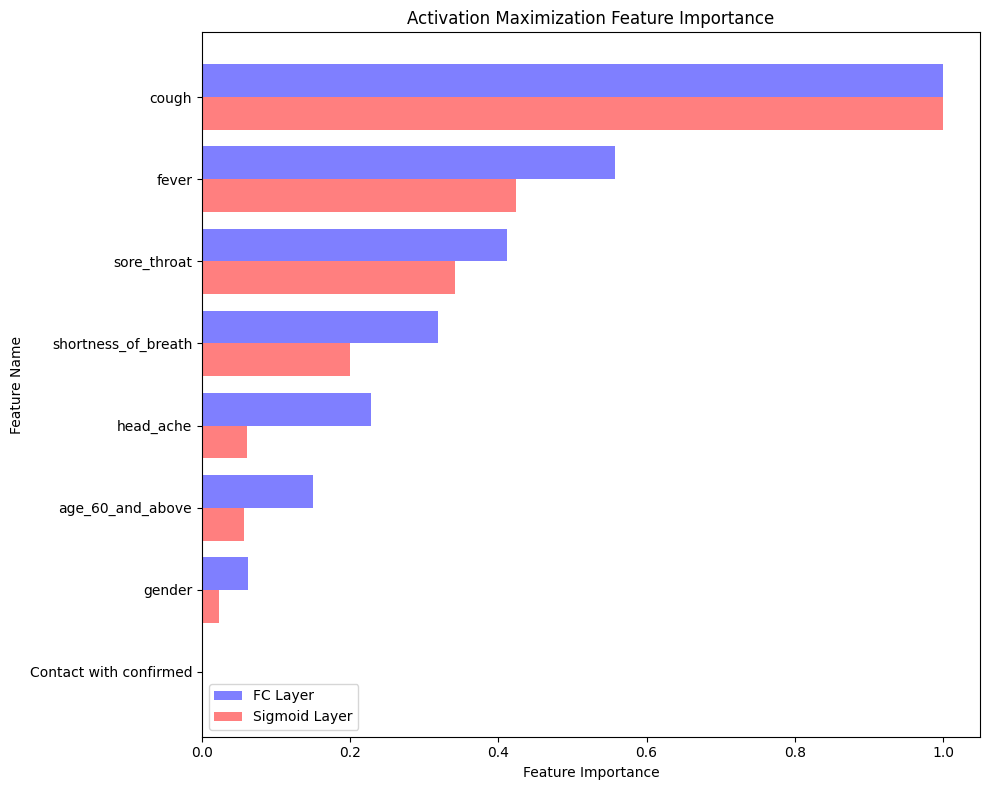

In [275]:
train_data = pd.read_csv('./Data/train_data.csv')
train_data_sub = train_data.sample(frac=0.05)
input_data = torch.tensor(train_data_sub.values, dtype=torch.float32)
#input_data = torch.tensor(train_data.values, dtype=torch.float32)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(input_data)
feat_num=X_normalized.shape[1]
X_normalized_tensor = torch.tensor(X_normalized)
 ####
# Forward pass
X_normalized_tensor = X_normalized_tensor.type_as(model.fc1.weight)
X_normalized_tensor = torch.where(torch.isnan(X_normalized_tensor), torch.zeros_like(X_normalized_tensor), X_normalized_tensor)


# Load your deep learning model (replace with your own model loading code)
model = ComplexLGBMModel(input_dim=feat_num, hidden_dim1=256, hidden_dim2=64, hidden_dim3=16)
model.load_state_dict(torch.load('./Covid_model.pth'))
# Create input data point
input_data = X_normalized_tensor.clone().detach().requires_grad_(True)  # Adjust the input shape to match your model's input size

fc1_feat,sig_fet=analyze_feature_importance(model, train_data, input_data, num_iterations=1000)

Pruning

Weights are :[[-0.15825349 -0.19268416 -0.23989978 ...  0.03178371 -0.24707866
  -0.32245764]
 [-0.04107266 -0.25332683 -0.08063634 ... -0.0785968   0.33723044
   0.30770636]
 [ 0.04150722 -0.24483511  0.04924398 ... -0.11656878  0.31956518
   0.01473436]
 ...
 [-0.15825349 -0.19268416 -0.23989978 ...  0.03178371 -0.24707866
  -0.32245764]
 [-0.15825349 -0.19268416 -0.23989978 ...  0.03178371 -0.24707866
  -0.32245764]
 [-0.04107266 -0.25332683 -0.08063634 ... -0.0785968   0.33723044
   0.30770636]]


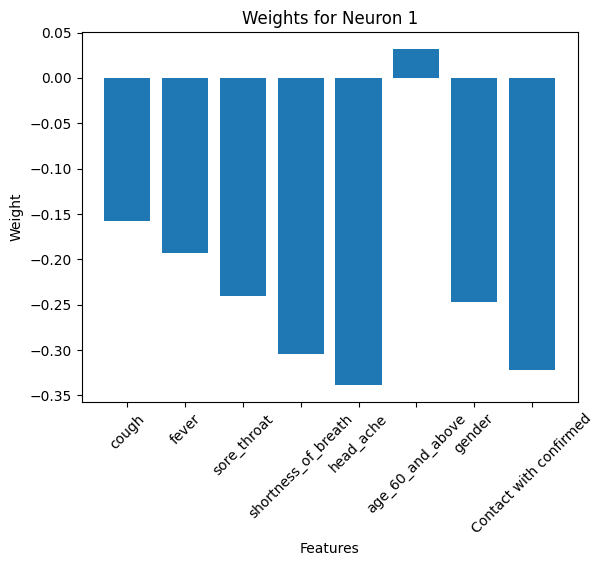

Weights are :[[-0.05788996 -0.27968496 -0.11480592 ...  0.10759417 -0.34388024
   0.10660019]
 [ 0.04150722 -0.24483511  0.04924398 ... -0.11656878  0.31956518
   0.01473436]
 [-0.04107266 -0.25332683 -0.08063634 ... -0.0785968   0.33723044
   0.30770636]
 ...
 [-0.34873664  0.01005374 -0.03505868 ...  0.34104204 -0.04056614
  -0.02481565]
 [-0.05788996 -0.27968496 -0.11480592 ...  0.10759417 -0.34388024
   0.10660019]
 [ 0.04150722 -0.24483511  0.04924398 ... -0.11656878  0.31956518
   0.01473436]]


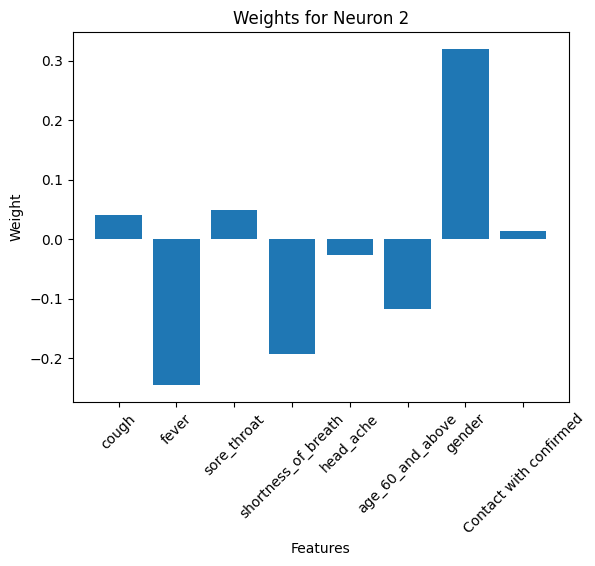

Weights are :[[-0.15951702  0.20450693  0.09446554 ... -0.09544013 -0.31917727
   0.15471494]
 [-0.27105853 -0.22437067  0.13589829 ... -0.103655    0.32801363
  -0.00469146]
 [-0.27105853 -0.22437067  0.13589829 ... -0.103655    0.32801363
  -0.00469146]
 ...
 [-0.35010585  0.00141812  0.25143942 ...  0.32579026  0.04897741
  -0.31385708]
 [-0.15951702  0.20450693  0.09446554 ... -0.09544013 -0.31917727
   0.15471494]
 [-0.27105853 -0.22437067  0.13589829 ... -0.103655    0.32801363
  -0.00469146]]


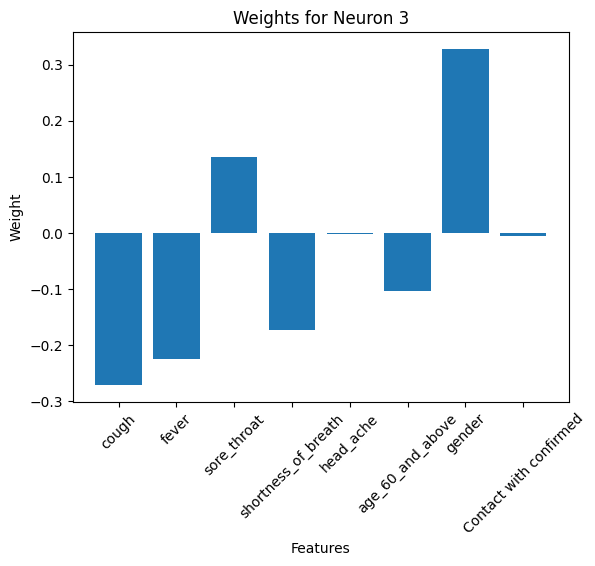

Weights are :[[ 0.10916904 -0.16706593  0.11350363 ...  0.16730507 -0.33776593
  -0.3055276 ]
 [-0.26108095  0.05153595  0.25243837 ...  0.07082645  0.28423843
  -0.05341036]
 [ 0.12421258 -0.05978969 -0.23091258 ... -0.24737416  0.30921963
   0.2191931 ]
 ...
 [-0.14553697 -0.34464163 -0.09955177 ...  0.19166462  0.19930983
  -0.19859613]
 [ 0.10916904 -0.16706593  0.11350363 ...  0.16730507 -0.33776593
  -0.3055276 ]
 [-0.26108095  0.05153595  0.25243837 ...  0.07082645  0.28423843
  -0.05341036]]


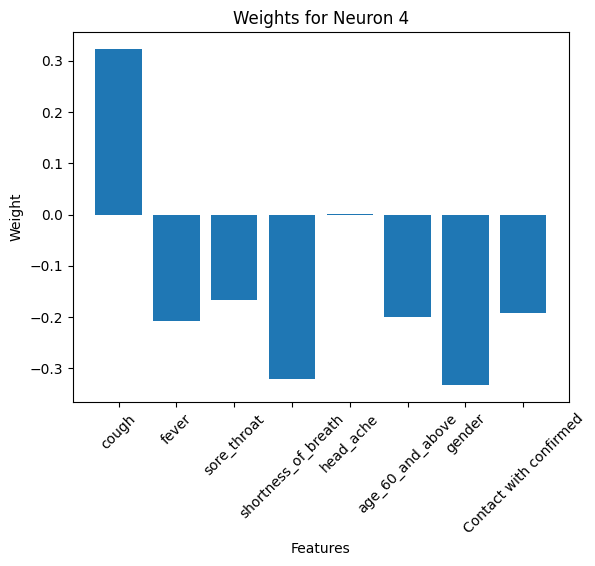

Weights are :[[ 0.01635298 -0.35219914 -0.20807284 ... -0.28876862 -0.26584083
  -0.14079267]
 [-0.14553697 -0.34464163 -0.09955177 ...  0.19166462  0.19930983
  -0.19859613]
 [ 0.2762877  -0.2395146  -0.1622806  ... -0.09686959  0.31668624
  -0.25135776]
 ...
 [ 0.01343821 -0.32390064 -0.19725715 ... -0.10315844  0.14518474
   0.01518713]
 [ 0.01635298 -0.35219914 -0.20807284 ... -0.28876862 -0.26584083
  -0.14079267]
 [-0.14553697 -0.34464163 -0.09955177 ...  0.19166462  0.19930983
  -0.19859613]]


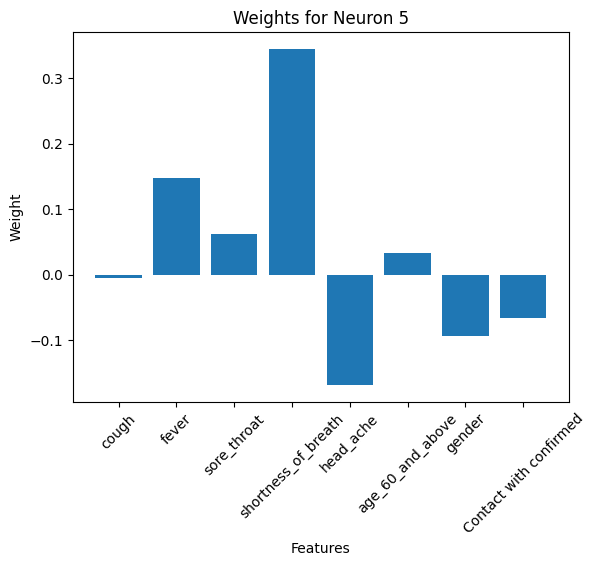

Weights are :[[ 0.3230794  -0.20826599 -0.16650817 ... -0.20054981 -0.33256942
  -0.19167595]
 [-0.32140616 -0.16509831 -0.01497834 ...  0.03931976  0.2069958
  -0.07814518]
 [-0.32582667 -0.32875484 -0.10984004 ... -0.32564574  0.06616635
  -0.30176222]
 ...
 [-0.05788996 -0.27968496 -0.11480592 ...  0.10759417 -0.34388024
   0.10660019]
 [ 0.3230794  -0.20826599 -0.16650817 ... -0.20054981 -0.33256942
  -0.19167595]
 [-0.32140616 -0.16509831 -0.01497834 ...  0.03931976  0.2069958
  -0.07814518]]


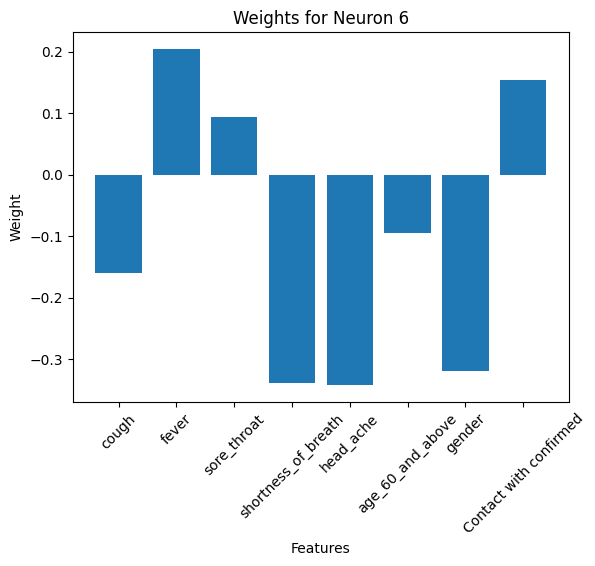

Weights are :[[-0.31270725 -0.3469825   0.21235041 ... -0.26223966 -0.2926424
   0.20060514]
 [ 0.2762877  -0.2395146  -0.1622806  ... -0.09686959  0.31668624
  -0.25135776]
 [ 0.01343821 -0.32390064 -0.19725715 ... -0.10315844  0.14518474
   0.01518713]
 ...
 [-0.32582667 -0.32875484 -0.10984004 ... -0.32564574  0.06616635
  -0.30176222]
 [-0.31270725 -0.3469825   0.21235041 ... -0.26223966 -0.2926424
   0.20060514]
 [ 0.2762877  -0.2395146  -0.1622806  ... -0.09686959  0.31668624
  -0.25135776]]


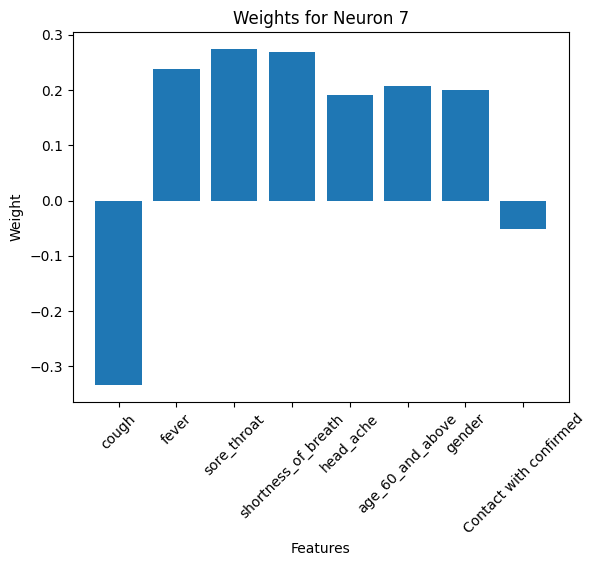

Weights are :[[-0.05943693 -0.33415747  0.26074016 ...  0.22937721 -0.34816393
   0.00623389]
 [ 0.01343821 -0.32390064 -0.19725715 ... -0.10315844  0.14518474
   0.01518713]
 [-0.26108095  0.05153595  0.25243837 ...  0.07082645  0.28423843
  -0.05341036]
 ...
 [-0.32140616 -0.16509831 -0.01497834 ...  0.03931976  0.2069958
  -0.07814518]
 [-0.05943693 -0.33415747  0.26074016 ...  0.22937721 -0.34816393
   0.00623389]
 [ 0.01343821 -0.32390064 -0.19725715 ... -0.10315844  0.14518474
   0.01518713]]


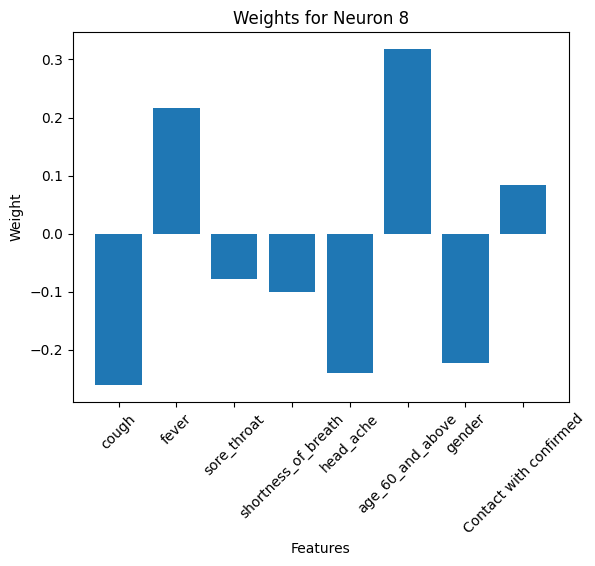

Weights are :[[-0.32205984 -0.0752193   0.27910185 ...  0.2713473  -0.34208307
   0.12147787]
 [ 0.2216827  -0.19608667 -0.22145572 ...  0.21063153  0.33695784
  -0.17823188]
 [-0.32140616 -0.16509831 -0.01497834 ...  0.03931976  0.2069958
  -0.07814518]
 ...
 [-0.2971755  -0.32226458 -0.28007364 ...  0.22615263 -0.10929313
  -0.07855769]
 [-0.32205984 -0.0752193   0.27910185 ...  0.2713473  -0.34208307
   0.12147787]
 [ 0.2216827  -0.19608667 -0.22145572 ...  0.21063153  0.33695784
  -0.17823188]]


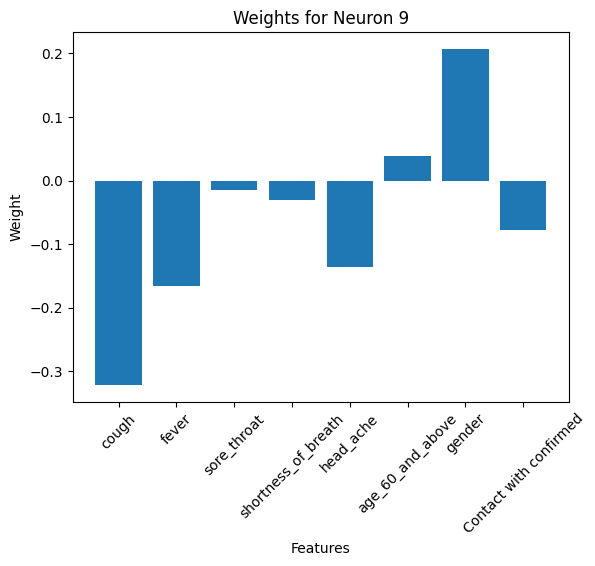

Weights are :[[ 0.04880568  0.23587675  0.31513456 ...  0.10765795 -0.34499726
  -0.11049901]
 [-0.2796333  -0.2030488   0.3348105  ...  0.18200658  0.31774324
  -0.32130376]
 [-0.1528936  -0.14103378  0.1868887  ... -0.24477375  0.26071787
   0.0410325 ]
 ...
 [ 0.04150722 -0.24483511  0.04924398 ... -0.11656878  0.31956518
   0.01473436]
 [ 0.04880568  0.23587675  0.31513456 ...  0.10765795 -0.34499726
  -0.11049901]
 [-0.2796333  -0.2030488   0.3348105  ...  0.18200658  0.31774324
  -0.32130376]]


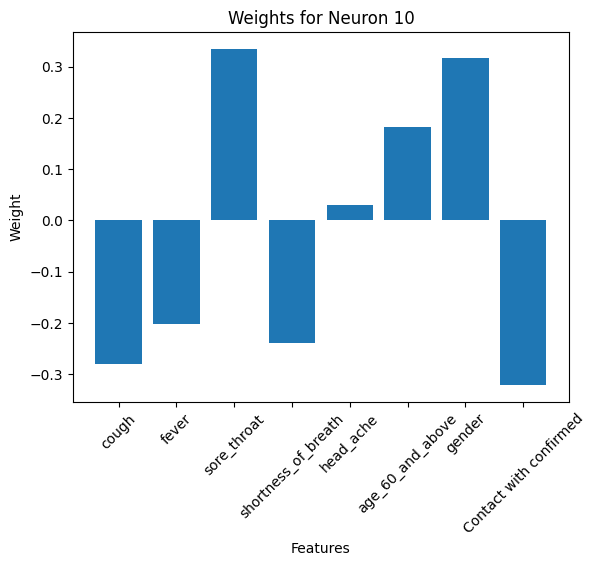

In [30]:
# Extract the feature names
K = 10 # the number of top nurons to look at
selected_feature_names = train_data.columns[:8]

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert the feature names to a NumPy array for plotting
feature_names_array = np.array(selected_feature_names)

# Assuming weights_top_k_neurons contains the weights of the top K neurons
for neuron_idx in range(K):
    weights = weights_top_k_neurons[:, neuron_idx].detach().cpu().numpy()  # Convert to NumPy array
    print(f'Weights are :{weights}')
    # Create a bar plot
  # Change this index to the neuron you want to visualize
    weights_for_neuron = weights[neuron_idx]
    # Create a bar plot
    plt.bar(selected_feature_names, weights_for_neuron)
    plt.xlabel('Features')
    plt.ylabel('Weight')
    plt.title(f'Weights for Neuron {neuron_idx + 1}')
    plt.xticks(rotation=45)
    plt.show()



Weights for best neuron are :tensor([-0.1583, -0.1927, -0.2399, -0.3048, -0.3385,  0.0318, -0.2471, -0.3225])


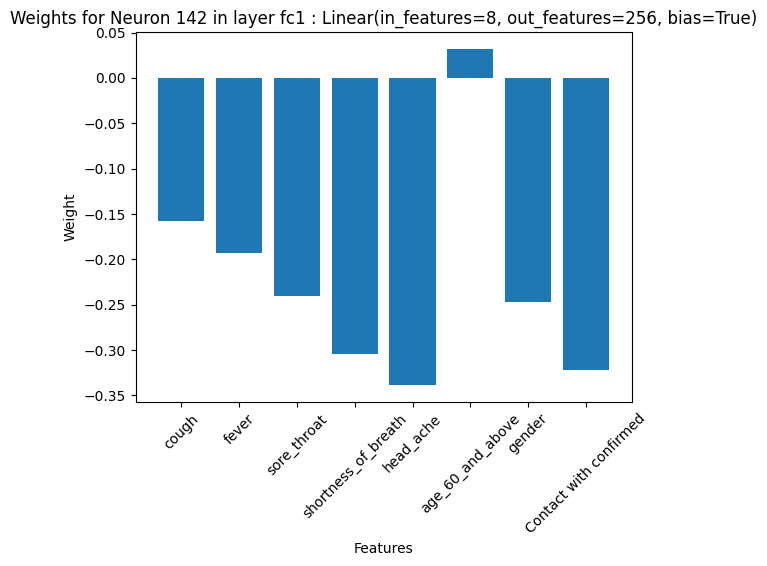

In [126]:
weights_top_neurons = weights_fc1[142]
#weights = weights_top_k_neurons[:,0].detach().cpu().numpy()  # Convert to NumPy array
print(f'Weights for best neuron are :{weights_top_neurons}')
#weights_for_neuron = weights[0]
# Create a bar plot
plt.bar(selected_feature_names, weights_top_neurons)
plt.xlabel('Features')
plt.ylabel('Weight')
plt.title(f'Weights for Neuron {142} in layer fc1 : {model.fc1}')
plt.xticks(rotation=45)
plt.show()


In [123]:
weights_fc2 = model.fc2.weight.data
# Print shape and values of activations_fc2
print("Shape of activations_fc1:", activations_fc2.shape)
print("Activations values:", activations_fc2)

# Find the most activated neuron
most_activated_neuron_index = torch.argmax(activations_fc2,dim=1)
print("Most activated neuron index:", most_activated_neuron_index)
max_activation= torch.argmax(activations_fc2, dim=1)
#overall_best_neuron_index = torch.max(max_activation)
overall_best_neuron_index=max_activation[0]

# Check the index
print(f"Over all Best Neuron in this layer is :{overall_best_neuron_index.item()}")

top_k_indices = torch.topk(activations_fc2, k=10).indices
weights_top_k_neurons = weights_fc2[top_k_indices]

Shape of activations_fc1: torch.Size([67948, 64])
Activations values: tensor([[-0.0353, -0.1142,  0.0449,  ...,  0.1420,  0.0318,  0.1790],
        [-0.0610,  0.0318,  0.1568,  ..., -0.0888, -0.0758,  0.2682],
        [-0.1144,  0.0586,  0.1172,  ..., -0.0174, -0.1448,  0.2764],
        ...,
        [-0.0654, -0.0409,  0.0646,  ...,  0.0017, -0.0285,  0.2297],
        [-0.0353, -0.1142,  0.0449,  ...,  0.1420,  0.0318,  0.1790],
        [-0.0610,  0.0318,  0.1568,  ..., -0.0888, -0.0758,  0.2682]],
       grad_fn=<AddmmBackward0>)
Most activated neuron index: tensor([52, 14, 14,  ..., 52, 52, 14])
Over all Best Neuron in this layer is :52


Weights for best neuron are :tensor([ 0.0473, -0.0319, -0.0085, -0.0558,  0.0509, -0.0052,  0.0533, -0.0093,
         0.0301,  0.0531,  0.0107,  0.0406, -0.0175,  0.0444, -0.0537, -0.0198,
         0.0251, -0.0355, -0.0558,  0.0448,  0.0507,  0.0393,  0.0040,  0.0621,
         0.0400,  0.0150, -0.0312,  0.0026,  0.0390,  0.0576, -0.0206, -0.0174,
         0.0055, -0.0517, -0.0458,  0.0141,  0.0583, -0.0050,  0.0477,  0.0216,
        -0.0474, -0.0293, -0.0171,  0.0389,  0.0057,  0.0298,  0.0092,  0.0327,
         0.0202,  0.0236,  0.0540,  0.0197, -0.0145,  0.0577,  0.0489,  0.0155,
        -0.0229,  0.0387,  0.0449, -0.0243, -0.0404,  0.0522, -0.0484,  0.0322,
        -0.0154, -0.0295,  0.0530,  0.0457,  0.0378, -0.0042,  0.0205, -0.0589,
        -0.0376, -0.0076, -0.0215,  0.0347,  0.0254, -0.0516, -0.0036, -0.0025,
         0.0244,  0.0021, -0.0047, -0.0582,  0.0283,  0.0631,  0.0024, -0.0267,
        -0.0275, -0.0364, -0.0500,  0.0630,  0.0156,  0.0072,  0.0008, -0.0315,
        -0.

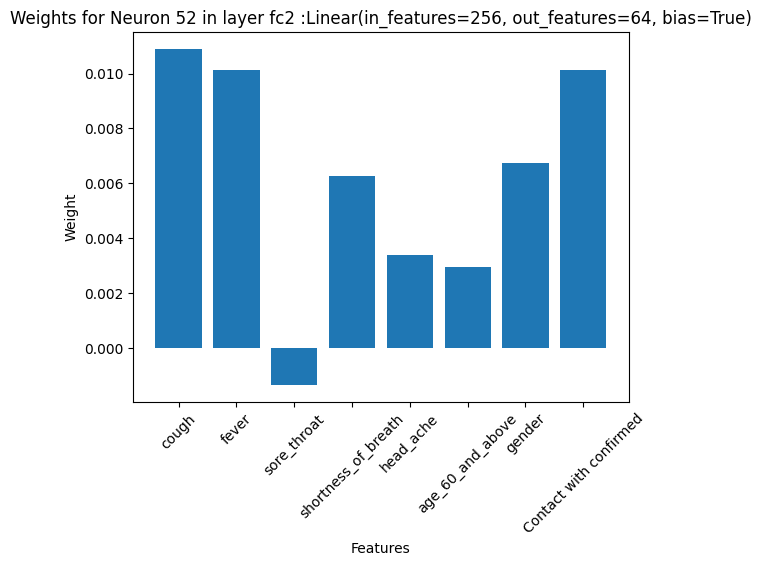

In [124]:
weights_top_neurons = weights_fc2[52]
#weights = weights_top_k_neurons[:,0].detach().cpu().numpy()  # Convert to NumPy array
print(f'Weights for best neuron are :{weights_top_neurons}')
#weights_for_neuron = weights[0]
weights_top_neurons = weights_top_neurons.reshape(8, -1)
mean_weights = weights_top_neurons.mean(dim=1).numpy()
# Create a bar plot
plt.bar(selected_feature_names, mean_weights)
plt.xlabel('Features')
plt.ylabel('Weight')
plt.title(f'Weights for Neuron {52} in layer fc2 :{model.fc2}')
plt.xticks(rotation=45)
plt.show()

Shape of activations_fc1: torch.Size([67948, 256])
Activations values: tensor([[-0.7021, -0.0491,  0.0353,  ..., -0.1444,  0.4001,  1.1995],
        [-0.0859,  0.2658,  0.1413,  ..., -0.1302, -0.0605,  0.5820],
        [ 0.0736,  0.0254, -0.2356,  ...,  0.0413, -0.4113, -0.1883],
        ...,
        [-0.5637, -0.1651, -0.0303,  ..., -0.1592,  0.3168,  1.1031],
        [-0.9099,  0.4278, -1.0749,  ..., -0.5063, -0.8542, -0.4801],
        [-0.0647,  0.1415, -0.1700,  ...,  0.0562, -0.3281, -0.0920]],
       grad_fn=<AddmmBackward0>)
Most activated neuron index: tensor([ 92, 176, 189,  ...,  92, 176, 142])
Over all Best Neuron in this layer is :92
Shape of activations_fc1: torch.Size([67948, 64])
Activations values: tensor([[-0.3585,  0.0214,  0.3349,  ...,  0.2208,  0.1386,  0.2425],
        [-0.0618,  0.0316,  0.1571,  ..., -0.0886, -0.0751,  0.2678],
        [-0.0303, -0.1033,  0.0121,  ...,  0.1620,  0.0058,  0.2111],
        ...,
        [-0.3747,  0.0249,  0.2581,  ...,  0.2917,  0

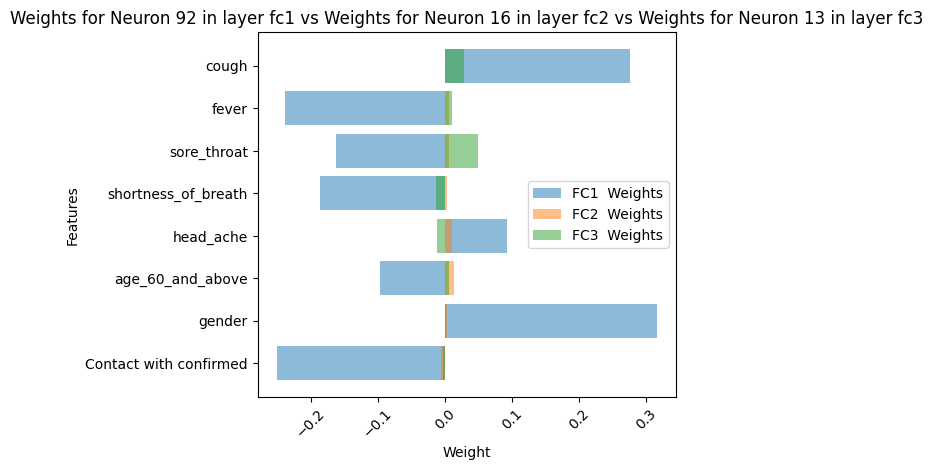

In [278]:
################### fc1 weigths #################
weights_fc1 = model.fc1.weight.data
# Print shape and values of activations_fc1
print("Shape of activations_fc1:", activations_fc1.shape)
print("Activations values:", activations_fc1)

# Find the most activated neuron
most_activated_neuron_index = torch.argmax(activations_fc1,dim=1)
print("Most activated neuron index:", most_activated_neuron_index)
max_activation= torch.argmax(activations_fc1, dim=1)
#overall_best_neuron_index = torch.max(max_activation)
overall_best_neuron_index_fc1=max_activation[0]

# Check the index
print(f"Over all Best Neuron in this layer is :{overall_best_neuron_index_fc1.item()}")

################# fc2 weights ################
weights_fc2 = model.fc2.weight.data
# Print shape and values of activations_fc2
print("Shape of activations_fc1:", activations_fc2.shape)
print("Activations values:", activations_fc2)

# Find the most activated neuron
most_activated_neuron_index = torch.argmax(activations_fc2,dim=1)
print("Most activated neuron index:", most_activated_neuron_index)
max_activation= torch.argmax(activations_fc2, dim=1)
#overall_best_neuron_index = torch.max(max_activation)
overall_best_neuron_index_fc2=max_activation[0]

# Check the index
print(f"Over all Best Neuron in this layer is :{overall_best_neuron_index_fc2.item()}")
################# fc3 weights ################
activations_fc3 = model.fc3(model.relu(model.fc2(model.relu(model.fc1(input_data)))))
weights_fc3 = model.fc3.weight.data
# Print shape and values of activations_fc2
print("Shape of activations_fc1:", activations_fc3.shape)
print("Activations values:", activations_fc3)

# Find the most activated neuron
most_activated_neuron_index = torch.argmax(activations_fc3,dim=1)
print("Most activated neuron index:", most_activated_neuron_index)
max_activation= torch.argmax(activations_fc3, dim=1)
#overall_best_neuron_index = torch.max(max_activation)
overall_best_neuron_index_fc3=max_activation[0]

# Check the index
print(f"Over all Best Neuron in this layer is :{overall_best_neuron_index_fc3.item()}")
############################################
weights_top_neurons_fc1 = weights_fc1[overall_best_neuron_index_fc1.item()]
#weights = weights_top_k_neurons[:,0].detach().cpu().numpy()  # Convert to NumPy array
print(f'Weights for best neuron are :{weights_top_neurons_fc1}')
#weights_for_neuron = weights[0]
#### fc2
weights_top_neurons_fc2 = weights_fc2[overall_best_neuron_index_fc2.item()]
#weights = weights_top_k_neurons[:,0].detach().cpu().numpy()  # Convert to NumPy array
print(f'Weights for best neuron are :{weights_top_neurons_fc2}')
#weights_for_neuron = weights[0]
weights_top_neurons_fc2 = weights_top_neurons_fc2.reshape(8, -1)
mean_weights_fc2 = weights_top_neurons_fc2.mean(dim=1).numpy()
#### fc3
weights_top_neurons_fc3 = weights_fc3[overall_best_neuron_index_fc3.item()]
#weights = weights_top_k_neurons[:,0].detach().cpu().numpy()  # Convert to NumPy array
print(f'Weights for best neuron are :{weights_top_neurons_fc3}')
#weights_for_neuron = weights[0]
weights_top_neurons_fc3 = weights_top_neurons_fc3.reshape(8, -1)
mean_weights_fc3 = weights_top_neurons_fc3.mean(dim=1).numpy()
bar_pos=0
bar_width=0.4
# Create a bar plot
plt.barh(selected_feature_names, weights_top_neurons_fc1,label='FC1  Weights',alpha=0.5)
plt.barh(selected_feature_names, mean_weights_fc2,label='FC2  Weights',alpha=0.5)
plt.barh(selected_feature_names, mean_weights_fc3,label='FC3  Weights',alpha=0.5)
plt.xlabel('Weight')
plt.ylabel('Features')
plt.title(f'Weights for Neuron {overall_best_neuron_index_fc1.item()} in layer fc1 vs Weights for Neuron {overall_best_neuron_index_fc2.item()} in layer fc2 vs Weights for Neuron {overall_best_neuron_index_fc3.item()} in layer fc3')
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.legend()
plt.show()

Pruning Model 

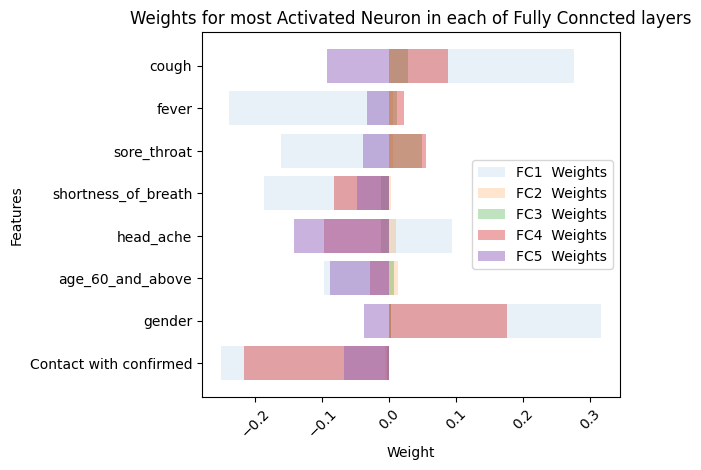

In [280]:
import torch.nn as nn

class PrunedLinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim, weights, bias):
        super(PrunedLinearLayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.fc.weight.data = weights
        self.fc.bias.data = bias

    def forward(self, x):
        return self.fc(x)

# List to store the pruned layers
pruned_layers = []

# Iterate through each layer and prune based on the best neuron index
for layer, neuron_index in zip([model.fc1, model.fc2, model.fc3, model.fc4, model.fc5],
                                [overall_best_neuron_index_fc1.item(), overall_best_neuron_index_fc2.item(), 
                                 overall_best_neuron_index_fc3.item(), overall_best_neuron_index_fc4.item(),
                                 overall_best_neuron_index_fc5.item()]):
    # Extract the weights and bias for the selected neuron
    weights = layer.weight.data[neuron_index]
    bias = layer.bias.data[neuron_index]
    
    # Create the pruned layer
    pruned_layer = PrunedLinearLayer(layer.in_features, layer.out_features, weights, bias)
    
    # Append the pruned layer to the list
    pruned_layers.append(pruned_layer)

# Now, pruned_layers contains the pruned layers for each layer in your model
pruned_model = nn.Sequential(*pruned_layers)

feature_importance = []  # List to store feature importance for each pruned layer

# Iterate through the pruned layers
for pruned_layer in pruned_layers:
    # Access the weights of the pruned neuron in each layer
    neuron_weights = pruned_layer.fc.weight.data.squeeze()  # Remove unnecessary dimensions
    feature_importance.append(neuron_weights.reshape(8, -1).mean(dim=1).numpy())

# feature_importance now contains the feature importance values for each pruned layer

###### plot #####
plt.barh(selected_feature_names, feature_importance[0],label='FC1  Weights',alpha=0.1)
plt.barh(selected_feature_names, feature_importance[1],label='FC2  Weights',alpha=0.2)
plt.barh(selected_feature_names, feature_importance[2],label='FC3  Weights',alpha=0.3)
plt.barh(selected_feature_names, feature_importance[3],label='FC4  Weights',alpha=0.4)
plt.barh(selected_feature_names, feature_importance[4],label='FC5  Weights',alpha=0.5)
plt.xlabel('Weight')
plt.ylabel('Features')
plt.title(f'Weights for most Activated Neuron in each of Fully Conncted layers' )
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [470]:
def prune_importnce(train_data,model):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    selected_feature_names = train_data.columns
    feat_num=len(selected_feature_names)
    ##### Loading data
    input_data = torch.tensor(train_data.values, dtype=torch.float32)
    #input_data = torch.tensor(train_data.values, dtype=torch.float32)
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(input_data)
    feat_num=X_normalized.shape[1]
    X_normalized_tensor = torch.tensor(X_normalized)
     ####
    # Forward pass
    X_normalized_tensor = X_normalized_tensor.type_as(model.fc1.weight)
    X_normalized_tensor = torch.where(torch.isnan(X_normalized_tensor), torch.zeros_like(X_normalized_tensor), X_normalized_tensor)



    # Create input data point
    input_data = X_normalized_tensor.clone().detach().requires_grad_(True) 
    model.eval()  # Set the model to evaluation mode
    print(model)
    with torch.no_grad():
        output = model(input_data)

    # Now, you can access the activations of specific layers
    # For example, to inspect the activations of the first hidden layer (fc1):
    activations_fc1 = model.fc1(input_data)
    # To inspect the activations of the second hidden layer (fc2):
    activations_fc2 = model.fc2(model.relu(model.fc1(input_data)))
    # To inspect the activations of the second hidden layer (fc3):
    activations_fc3 = model.fc3(model.relu(model.fc2(model.relu(model.fc1(input_data)))))
    # To inspect the activations of the second hidden layer (fc4):
    activations_fc4 = model.fc4(model.relu(model.fc3(model.relu(model.fc2(model.relu(model.fc1(input_data)))))))
    # To inspect the activations of the second hidden layer (fc5):
    activations_fc5 = model.fc5(model.fc4(model.relu(model.fc3(model.relu(model.fc2(model.relu(model.fc1(input_data))))))))



    #########
    ################### fc1 weigths #################
    weights_fc1 = model.fc1.weight.data
    # Print shape and values of activations_fc1
    print("Shape of activations_fc1:", activations_fc1.shape)
    print("Activations values:", activations_fc1)

    # Find the most activated neuron
    most_activated_neuron_index = torch.argmax(activations_fc1,dim=1)
    print("Most activated neuron index:", most_activated_neuron_index)
    max_activation= torch.argmax(activations_fc1, dim=1)
    #overall_best_neuron_index = torch.max(max_activation)
    overall_best_neuron_index_fc1=max_activation[0]

    # Check the index
    print(f"Over all Best Neuron in this layer is :{overall_best_neuron_index_fc1.item()}")

    ################# fc2 weights ################
    weights_fc2 = model.fc2.weight.data
    # Print shape and values of activations_fc2
    print("Shape of activations_fc1:", activations_fc2.shape)
    print("Activations values:", activations_fc2)

    # Find the most activated neuron
    most_activated_neuron_index = torch.argmax(activations_fc2,dim=1)
    print("Most activated neuron index:", most_activated_neuron_index)
    max_activation= torch.argmax(activations_fc2, dim=1)
    #overall_best_neuron_index = torch.max(max_activation)
    overall_best_neuron_index_fc2=max_activation[0]

    # Check the index
    print(f"Over all Best Neuron in this layer is :{overall_best_neuron_index_fc2.item()}")
    ################# fc3 weights ################
    weights_fc3 = model.fc3.weight.data
    # Print shape and values of activations_fc3
    print("Shape of activations_fc1:", activations_fc3.shape)
    print("Activations values:", activations_fc3)

    # Find the most activated neuron
    most_activated_neuron_index = torch.argmax(activations_fc3,dim=1)
    print("Most activated neuron index:", most_activated_neuron_index)
    max_activation= torch.argmax(activations_fc3, dim=1)
    #overall_best_neuron_index = torch.max(max_activation)
    overall_best_neuron_index_fc3=max_activation[0]

    # Check the index
    print(f"Over all Best Neuron in this layer is :{overall_best_neuron_index_fc3.item()}")

    ################# fc4 weights ################
    weights_fc4 = model.fc4.weight.data
    # Print shape and values of activations_fc4
    print("Shape of activations_fc1:", activations_fc4.shape)
    print("Activations values:", activations_fc4)

    # Find the most activated neuron
    most_activated_neuron_index = torch.argmax(activations_fc4,dim=1)
    print("Most activated neuron index:", most_activated_neuron_index)
    max_activation= torch.argmax(activations_fc4, dim=1)
    #overall_best_neuron_index = torch.max(max_activation)
    overall_best_neuron_index_fc4=max_activation[0]

    # Check the index
    print(f"Over all Best Neuron in this layer is :{overall_best_neuron_index_fc4.item()}")

    ################# fc5 weights ################
    weights_fc5 = model.fc5.weight.data
    # Print shape and values of activations_fc5
    print("Shape of activations_fc1:", activations_fc5.shape)
    print("Activations values:", activations_fc5)

    # Find the most activated neuron
    most_activated_neuron_index = torch.argmax(activations_fc5,dim=1)
    print("Most activated neuron index:", most_activated_neuron_index)
    max_activation= torch.argmax(activations_fc5, dim=1)
    #overall_best_neuron_index = torch.max(max_activation)
    overall_best_neuron_index_fc5=max_activation[0]

    # Check the index
    print(f"Over all Best Neuron in this layer is :{overall_best_neuron_index_fc5.item()}")

    ############################################



    weights_top_neurons_fc1 = weights_fc1[overall_best_neuron_index_fc1.item()]
    #weights = weights_top_k_neurons[:,0].detach().cpu().numpy()  # Convert to NumPy array
    print(f'Weights for best neuron are :{weights_top_neurons_fc1}')
    #weights_for_neuron = weights[0]

    ############################  fc2 ##################################
    weights_top_neurons_fc2 = weights_fc2[overall_best_neuron_index_fc2.item()]
    #weights = weights_top_k_neurons[:,0].detach().cpu().numpy()  # Convert to NumPy array
    print(f'Weights for best neuron are :{weights_top_neurons_fc2}')
    #weights_for_neuron = weights[0]
    feature_importance1 = weights_fc2.abs().sum(dim=1)
    print(feature_importance1)

    #weights_top_neurons_fc2 = weights_top_neurons_fc2.view(feat_num, -1)
    #mean_weights_fc2 = weights_top_neurons_fc2.mean(dim=1).numpy()
    weights_top_neurons_fc2 = weights_top_neurons_fc2[:feat_num]
    mean_weights_fc2=weights_top_neurons_fc2.numpy()

    ####################### fc3  ##################################
    weights_top_neurons_fc3 = weights_fc3[overall_best_neuron_index_fc3.item()]
    #weights = weights_top_k_neurons[:,0].detach().cpu().numpy()  # Convert to NumPy array
    print(f'Weights for best neuron are :{weights_top_neurons_fc3}')
    #weights_for_neuron = weights[0]
    #weights_top_neurons_fc3 = weights_top_neurons_fc3.reshape(feat_num, -1)
    #mean_weights_fc3 = weights_top_neurons_fc3.mean(dim=1).numpy()
    weights_top_neurons_fc3 = weights_top_neurons_fc3[:feat_num]
    mean_weights_fc3=weights_top_neurons_fc3.numpy()


    ####################### fc4  ##################################
    weights_top_neurons_fc4 = weights_fc4[overall_best_neuron_index_fc4.item()]
    #weights = weights_top_k_neurons[:,0].detach().cpu().numpy()  # Convert to NumPy array
    print(f'Weights for best neuron are :{weights_top_neurons_fc3}')
    #weights_for_neuron = weights[0]
    #weights_top_neurons_fc4 = weights_top_neurons_fc4.reshape(8, -1)
    #mean_weights_fc4 = weights_top_neurons_fc4.mean(dim=1).numpy()
    weights_top_neurons_fc4 = weights_top_neurons_fc4[:feat_num]
    mean_weights_fc4=weights_top_neurons_fc4.numpy()


    ####################### fc5  ##################################
    weights_top_neurons_fc5 = weights_fc3[overall_best_neuron_index_fc5.item()]
    #weights = weights_top_k_neurons[:,0].detach().cpu().numpy()  # Convert to NumPy array
    print(f'Weights for best neuron are :{weights_top_neurons_fc5}')
    #weights_for_neuron = weights[0]
    #weights_top_neurons_fc5 = weights_top_neurons_fc5.reshape(feat_num, -1)
    #mean_weights_fc5 = weights_top_neurons_fc5.mean(dim=1).numpy()
    weights_top_neurons_fc5 = weights_top_neurons_fc5[:feat_num]
    mean_weights_fc5=weights_top_neurons_fc5.numpy()

    most_activated=[overall_best_neuron_index_fc1.item(),overall_best_neuron_index_fc2.item(),overall_best_neuron_index_fc3.item(),overall_best_neuron_index_fc4.item(),overall_best_neuron_index_fc5.item()]
    print(f'Most activated Nureons in each layer are :{most_activated}')



    import torch.nn as nn

    class PrunedLinearLayer(nn.Module):
        def __init__(self, input_dim, output_dim, weights, bias):
            super(PrunedLinearLayer, self).__init__()
            self.fc = nn.Linear(input_dim, output_dim)
            self.fc.weight.data = weights
            self.fc.bias.data = bias

        def forward(self, x):
            return self.fc(x)

    # List to store the pruned layers
    pruned_layers = []

    # Iterate through each layer and prune based on the best neuron index
    for layer, neuron_index in zip([model.fc1, model.fc2, model.fc3, model.fc4, model.fc5],
                                    [overall_best_neuron_index_fc1.item(), overall_best_neuron_index_fc2.item(), 
                                     overall_best_neuron_index_fc3.item(), overall_best_neuron_index_fc4.item(),
                                     overall_best_neuron_index_fc5.item()]):
        # Extract the weights and bias for the selected neuron
        weights = layer.weight.data[neuron_index]
        bias = layer.bias.data[neuron_index]

        # Create the pruned layer
        pruned_layer = PrunedLinearLayer(layer.in_features, layer.out_features, weights, bias)

        # Append the pruned layer to the list
        pruned_layers.append(pruned_layer)

    # Now, pruned_layers contains the pruned layers for each layer in your model
    # Extract original model architecture
    input_dim = feat_num
    hidden_dim1 = 256
    hidden_dim2 = 64
    hidden_dim3 = 16
    
    layer_parameters1 = model.fc1.parameters()  # Replace fc1 with the specific layer you want to access

    # Extract the weights and biases
    weights1, biases1 = list(layer_parameters1)
    layer_parameters2 = model.fc2.parameters()  # Replace fc1 with the specific layer you want to access

    # Extract the weights and biases
    weights2, biases2 = list(layer_parameters2)
    layer_parameters3 = model.fc3.parameters()  # Replace fc1 with the specific layer you want to access

    # Extract the weights and biases
    weights3, biases3 = list(layer_parameters3)

    pruned_layer1 = PrunedLinearLayer(input_dim, hidden_dim1, weights1, biases1)
    pruned_layer2 = PrunedLinearLayer(hidden_dim1, hidden_dim2, weights2, biases2)
    pruned_layer3 = PrunedLinearLayer(hidden_dim2, hidden_dim3, weights3, biases3)
    

    pruned_model = nn.Sequential(
        pruned_layer1,
        pruned_layer2,
        pruned_layer3
    )

    def calculate_feature_importance(model,feat_num):
        weights_fc1 = model[0].fc.weight.data.abs().mean(dim=0)[:feat_num] # Access the first layer's weights
        weights_fc2 = model[1].fc.weight.data.abs().mean(dim=0)[:feat_num]  # Access the second layer's weights
        weights_fc3 = model[2].fc.weight.data.abs().mean(dim=0)[:feat_num] 
        feature_importance = torch.stack([weights_fc1, weights_fc2, weights_fc3]).mean(dim=0)
        min_value = feature_importance.min()
        max_value = feature_importance.max()

        # Min-Max normalization
        normalized_feature_importance = (feature_importance - min_value) / (max_value - min_value)
        #df = pd.DataFrame({'Feature Importance': normalized_feature_importance})
        return normalized_feature_importance
    

    
    
    feature_importance=calculate_feature_importance(pruned_model,feat_num)
    sorted_tensor, sorted_indices = torch.sort(feature_importance, descending=True)
    selected_feature_names=train_data.columns[sorted_indices]
    plt.barh(selected_feature_names, sorted_tensor,alpha=0.4)
    plt.xlabel('Imoprtance Rank')
    plt.ylabel('Features')
    plt.title(f'Feature Importance After Pruning' )
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show
    print(selected_feature_names)
    return selected_feature_names,sorted_indices

ComplexLGBMModel(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
Shape of activations_fc1: torch.Size([226494, 256])
Activations values: tensor([[-0.0841,  0.2675,  0.1402,  ..., -0.1298, -0.0613,  0.5810],
        [-0.6995, -0.0469,  0.0343,  ..., -0.1439,  0.3986,  1.1976],
        [-0.0442,  0.5000, -0.4787,  ...,  0.6032, -0.0663, -0.8199],
        ...,
        [-0.0737,  0.2062, -0.0133,  ..., -0.0379, -0.1933,  0.2487],
        [-1.0373,  0.4846, -1.1653,  ..., -0.3995, -0.9046, -0.7182],
        [-0.0737,  0.2062, -0.0133,  ..., -0.0379, -0.1933,  0.2487]],
       grad_fn=<AddmmBackward0>)
Most activated neuron index: tensor([176,  92,  63,  ..., 142,   8, 142])
Over all Best Neuron in thi

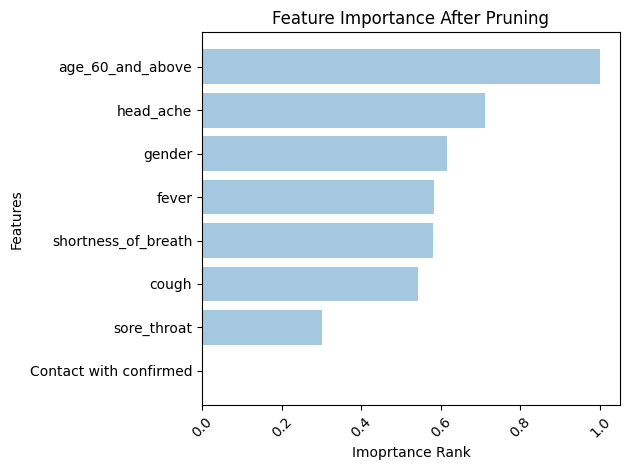

In [474]:
# Load your deep learning model (replace with your own model loading code)
model = ComplexLGBMModel(input_dim=feat_num, hidden_dim1=256, hidden_dim2=64, hidden_dim3=16)
model.load_state_dict(torch.load('./Covid_model.pth'))
train_data = pd.read_csv('./Data/train_data.csv')
#train_data_sub = train_data.sample(frac=0.3)


selected_features_covid_prune,importance_covid_prune = prune_importnce(train_data,model)

ImprovedModel(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=16, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.15, inplace=False)
  (sigmoid): Sigmoid()
)
Shape of activations_fc1: torch.Size([6036, 256])
Activations values: tensor([[ 0.0572, -0.7365, -0.0904,  ..., -0.2659,  0.3872,  0.0858],
        [-0.9726,  0.1899, -0.0350,  ..., -0.2982,  0.2737,  0.1241],
        [-1.1077, -1.0308, -0.8118,  ..., -0.2376,  0.0613, -0.0598],
        ...,
        [ 0.1

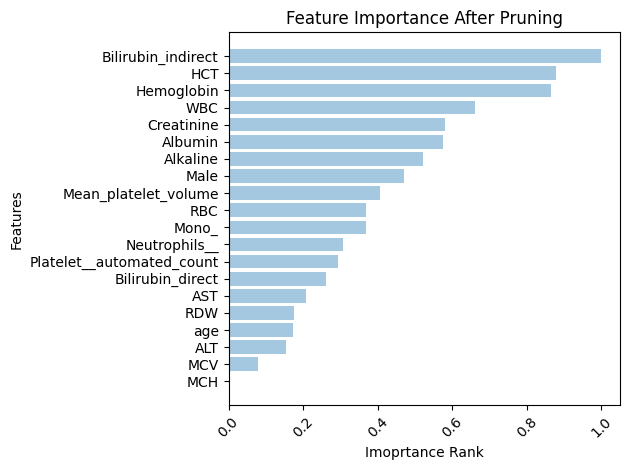

In [473]:
# Load your deep learning model (replace with your own model loading code)
model_blood = ImprovedModel(input_dim=20, hidden_dim1=256, hidden_dim2=64, hidden_dim3=16)
model_blood.load_state_dict(torch.load('./Blood_model.pth'))

train_data = pd.read_csv('./Data/train_blood.csv')

selected_features_names_blood_prune,importance_features_blood_prune = prune_importnce(train_data,model_blood)

In [502]:
data_dict = json.loads(sesntivity_covid)

# Extract the keys (names)
names = list(data_dict.keys())

# Create a DataFrame from the names
df_covid = pd.DataFrame(names, columns=["Sesntivity"])

print(df_covid)

               Sesntivity
0                   fever
1  Contact with confirmed
2               head_ache
3                  gender
4     shortness_of_breath
5                   cough
6             sore_throat
7        age_60_and_above


In [503]:
Gradiant_covid

{'gender': 1.0,
 'age_60_and_above': 0.2695627212524414,
 'sore_throat': 0.25290316343307495,
 'shortness_of_breath': 0.2496519237756729,
 'head_ache': 0.24248826503753662,
 'Contact with confirmed': 0.15731842815876007,
 'cough': 0.1020435020327568,
 'fever': 0.0}

In [509]:
blood_sig.columns

Index(['age', 'Mono_', 'Male', 'ALT', 'AST', 'Albumin', 'Alkaline',
       'Bilirubin_direct', 'Bilirubin_indirect', 'Creatinine', 'HCT',
       'Hemoglobin', 'MCH', 'MCV', 'Mean_platelet_volume', 'Neutrophils__',
       'Platelet__automated_count', 'RBC', 'RDW', 'WBC'],
      dtype='object')

In [510]:
sig_fet.columns

Index(['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache',
       'age_60_and_above', 'gender', 'Contact with confirmed'],
      dtype='object')

In [511]:
selected_features_covid_prune


array(['age_60_and_above', 'head_ache', 'gender', 'fever',
       'shortness_of_breath', 'cough', 'sore_throat',
       'Contact with confirmed'], dtype=object)

In [530]:
import pandas as pd
import json

data1 =sesntivity_covid

data2 = Gradiant_covid

# Parse the JSON data
data_dict1 = json.loads(data1)
data_dict2 = json.dumps(data2)
data_dict2 = json.loads(data_dict2)

# Extract the keys (names)
names1 = list(data_dict1.keys())
names2 = list(data_dict2.keys())

# Create a DataFrame from the names in data1
df1 = pd.DataFrame(names1, columns=["Senstivitey"])

# Add the names from data2 to the DataFrame
df2 = pd.DataFrame(names2, columns=["Gradinet"])

# Additional names to add
additional_names = sig_fet.columns

# Add the additional names to the DataFrame
df3 = pd.DataFrame(additional_names, columns=["Activated Sigmoid"])

# Additional array of names to add
array_of_names = selected_features_covid_prune

# Add the array of names to the DataFrame
df4 = pd.DataFrame(array_of_names, columns=["Prune Activation"])

covid_importance_names_df = pd.concat([df1, df2, df3,df4], axis=1)
#covid_importance_names_df.reset_index(drop=True, inplace=True)

print(covid_importance_names_df)


              Senstivitey                Gradinet       Activated Sigmoid  \
0                   fever                  gender                   cough   
1  Contact with confirmed        age_60_and_above                   fever   
2               head_ache             sore_throat             sore_throat   
3                  gender     shortness_of_breath     shortness_of_breath   
4     shortness_of_breath               head_ache               head_ache   
5                   cough  Contact with confirmed        age_60_and_above   
6             sore_throat                   cough                  gender   
7        age_60_and_above                   fever  Contact with confirmed   

         Prune Activation  
0        age_60_and_above  
1               head_ache  
2                  gender  
3                   fever  
4     shortness_of_breath  
5                   cough  
6             sore_throat  
7  Contact with confirmed  


Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 0.0418
Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 0.0452
Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Started Model Training and Optimzation
Epoch [0/100], Loss: 0.2488
Accuracy: 0.9248689695018778
ROC AUC: 0.8467045523405528


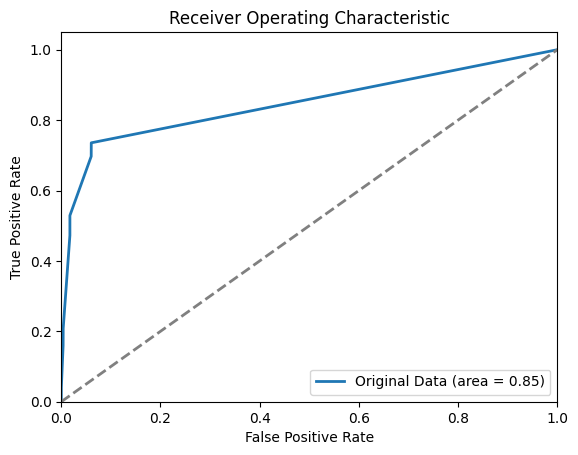

Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 0.1443
Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 0.2531
Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Started Model Training and Optimzation
Epoch [0/100], Loss: 0.2069
Accuracy: 0.9248689695018778
ROC AUC: 0.5759160085660644


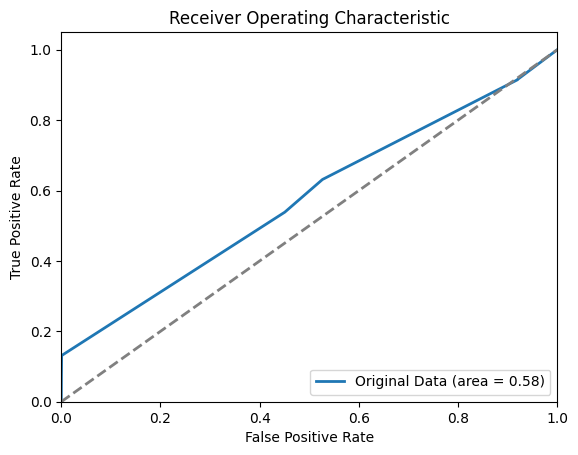

Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 0.0808
Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 0.0844
Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Started Model Training and Optimzation
Epoch [0/100], Loss: 0.2556
Accuracy: 0.9248689695018778
ROC AUC: 0.7449874538630611


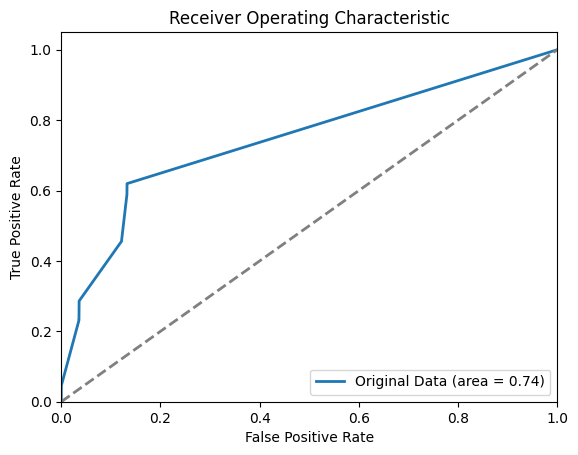

KeyError: 'Prune Activation Sigmoid'

In [533]:
train_data = pd.read_csv('./Data/train_data.csv')
test_data = pd.read_csv('./Data/test_data.csv')
train_labels = pd.read_csv('./Data/train_labels.csv')
test_labels = pd.read_csv('./Data/test_labels.csv')

model_type = "lgbm"
feature_importance_type = "..."

#____________________________ SESETIVITY ___________________________________#
ses=covid_importance_names_df["Senstivitey"][:3].values
model_name="Senstivity_covid"
feature_importance_type="..."
fpr_ses, tpr_ses,preds_ses = interpretation(train_data[ses], test_data[ses], train_labels, test_labels, model_type, feature_importance_type,model_name)
#____________________________ Gradinet ___________________________________#
grad=covid_importance_names_df["Gradinet"][:3].values
model_name="Gradinet_covid"
feature_importance_type="..."
fpr_grad, tpr_grad,preds_grad = interpretation(train_data[grad], test_data[grad], train_labels, test_labels, model_type, feature_importance_type,model_name)
#____________________________ Sigmoid ___________________________________#
sig=covid_importance_names_df["Activated Sigmoid"][:3].values
model_name="Activated Sigmoid_covid"
feature_importance_type="..."
fpr_sig, tpr_sig,preds_sig = interpretation(train_data[sig], test_data[sig], train_labels, test_labels, model_type, feature_importance_type,model_name)
#____________________________ Prune Activation ___________________________________#
prune=covid_importance_names_df["Prune Activation"][:3].values
model_name="Prune Activation_covid"
feature_importance_type="..."
fpr_prune, tpr_prune,preds_prune = interpretation(train_data[prune], test_data[prune], train_labels, test_labels, model_type, feature_importance_type,model_name)

Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 0.2089
Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 0.2273
Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Started Model Training and Optimzation
Epoch [0/100], Loss: 0.2039
Accuracy: 0.9248689695018778
ROC AUC: 0.6096841186352664


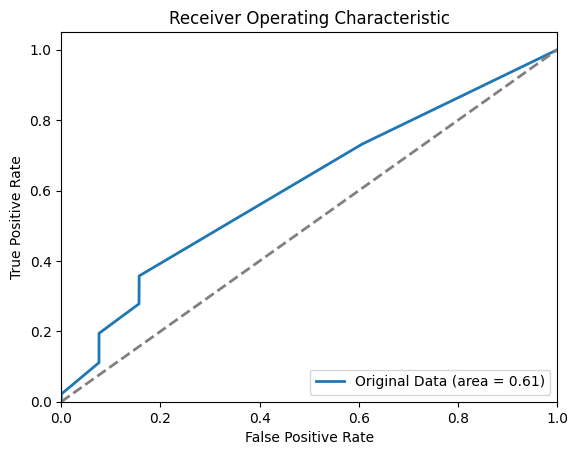

In [535]:
prune=covid_importance_names_df["Prune Activation"][:3].values
model_name="Prune Activation_covid"
feature_importance_type="..."
fpr_prune, tpr_prune,preds_prune = interpretation(train_data[prune], test_data[prune], train_labels, test_labels, model_type, feature_importance_type,model_name)

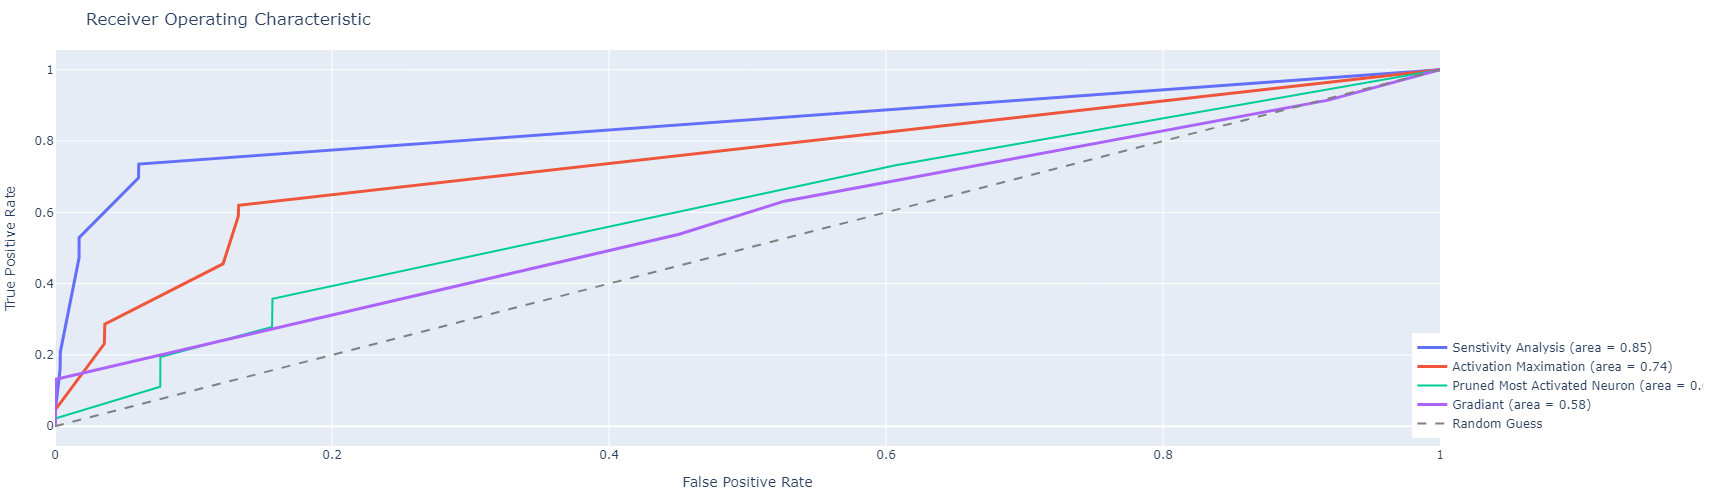

In [543]:
import plotly.graph_objects as go

# Create traces
trace_original = go.Scatter(x=fpr_ses, y=tpr_ses, mode='lines', name='Senstivity Analysis (area = {:.2f})'.format(roc_auc_score(test_labels, preds_ses)), line=dict(width=3))
trace_10_percent = go.Scatter(x=fpr_grad, y=tpr_grad, mode='lines', name='Gradiant (area = {:.2f})'.format(roc_auc_score(test_labels, preds_grad)), line=dict(width=3))
trace_20_percent = go.Scatter(x=fpr_sig, y=tpr_sig, mode='lines', name='Activation Maximation (area = {:.2f})'.format(roc_auc_score(test_labels, preds_sig)), line=dict(width=3))
trace_30_percent = go.Scatter(x=fpr_prune, y=tpr_prune, mode='lines', name='Pruned Most Activated Neuron (area = {:.2f})'.format(roc_auc_score(test_labels, preds_prune), line=dict(width=3)))
line_gray = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Guess', line=dict(color='gray', dash='dash', width=2))

data = [trace_original, trace_20_percent,trace_30_percent, trace_10_percent, line_gray]

# Layout settings
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    legend=dict(x=0.98, y=0.02),  # Bottom right corner
    margin=dict(l=50, r=20, t=50, b=50),
    width=800,
    height=500
)

# Create figure
fig = go.Figure(data=data, layout=layout)

# Show plot
fig.show()

In [546]:
import pandas as pd
import json

data1 =sesetvity_blood

data2 = Gradiant_blood

# Parse the JSON data
data_dict1 = json.loads(data1)
data_dict2 = json.dumps(data2)
data_dict2 = json.loads(data_dict2)

# Extract the keys (names)
names1 = list(data_dict1.keys())
names2 = list(data_dict2.keys())

# Create a DataFrame from the names in data1
df1 = pd.DataFrame(names1, columns=["Senstivitey"])

# Add the names from data2 to the DataFrame
df2 = pd.DataFrame(names2, columns=["Gradinet"])

# Additional names to add
additional_names = blood_sig.columns

# Add the additional names to the DataFrame
df3 = pd.DataFrame(additional_names, columns=["Activated Sigmoid"])

# Additional array of names to add
array_of_names = selected_features_names_blood_prune

# Add the array of names to the DataFrame
df4 = pd.DataFrame(array_of_names, columns=["Prune Activation"])

blood_importance_names_df = pd.concat([df1, df2, df3,df4], axis=1)
#covid_importance_names_df.reset_index(drop=True, inplace=True)

print(blood_importance_names_df)

                  Senstivitey                   Gradinet  \
0                         RDW                        RDW   
1                         age                        WBC   
2                     Albumin  Platelet__automated_count   
3   Platelet__automated_count                 Creatinine   
4                         HCT                        age   
5                       Mono_       Mean_platelet_volume   
6                         WBC              Neutrophils__   
7                  Creatinine         Bilirubin_indirect   
8        Mean_platelet_volume                       Male   
9               Neutrophils__                   Alkaline   
10                       Male                        AST   
11                 Hemoglobin                        MCV   
12           Bilirubin_direct                        MCH   
13                        MCV           Bilirubin_direct   
14                        ALT                        ALT   
15                        RBC           

Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 12076.6191
Epoch [100/1000], Loss: 9.0119
Epoch [200/1000], Loss: 0.2000
Epoch [300/1000], Loss: 0.0871
Epoch [400/1000], Loss: 0.0595
Epoch [500/1000], Loss: 0.0455
Epoch [600/1000], Loss: 0.0365
Epoch [700/1000], Loss: 0.0300
Epoch [800/1000], Loss: 0.0253
Epoch [900/1000], Loss: 0.0224
Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 13592.7744
Epoch [100/1000], Loss: 8.1944
Epoch [200/1000], Loss: 0.5567
Epoch [300/1000], Loss: 0.1251
Epoch [400/1000], Loss: 0.0854
Epoch [500/1000], Loss: 0.0649
Epoch [600/1000], Loss: 0.0582
Epoch [700/1000], Loss: 0.0517
Epoch [800/1000], Loss: 0.0375
Epoch [900/1000], Loss: 0.0328
Started Model Training and Optimzation
Epoch [0/1000], Loss: 0.2292
Epoch [100/1000], Loss: 0.2130
Epoch [200/1000], Loss: 0.2080
Epoch [300/1000], Loss: 0.2043
Epoch [400/1000], Loss: 0.2095
Epoch [500/1000], Loss: 0.1997
Epoch [600/1000], Loss: 0.198

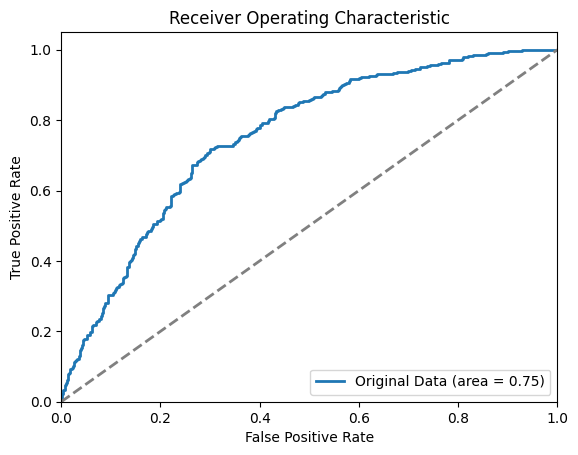

Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 12146.0801
Epoch [100/1000], Loss: 3.7785
Epoch [200/1000], Loss: 0.4230
Epoch [300/1000], Loss: 0.1989
Epoch [400/1000], Loss: 0.0722
Epoch [500/1000], Loss: 0.0478
Epoch [600/1000], Loss: 0.0301
Epoch [700/1000], Loss: 0.0248
Epoch [800/1000], Loss: 0.0211
Epoch [900/1000], Loss: 0.0208
Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 14581.9395
Epoch [100/1000], Loss: 3.4948
Epoch [200/1000], Loss: 0.3926
Epoch [300/1000], Loss: 0.2801
Epoch [400/1000], Loss: 0.1627
Epoch [500/1000], Loss: 0.0640
Epoch [600/1000], Loss: 0.0309
Epoch [700/1000], Loss: 0.0228
Epoch [800/1000], Loss: 0.0189
Epoch [900/1000], Loss: 0.0176
Started Model Training and Optimzation
Epoch [0/1000], Loss: 0.2520
Epoch [100/1000], Loss: 0.2113
Epoch [200/1000], Loss: 0.2068
Epoch [300/1000], Loss: 0.2026
Epoch [400/1000], Loss: 0.2009
Epoch [500/1000], Loss: 0.1990
Epoch [600/1000], Loss: 0.208

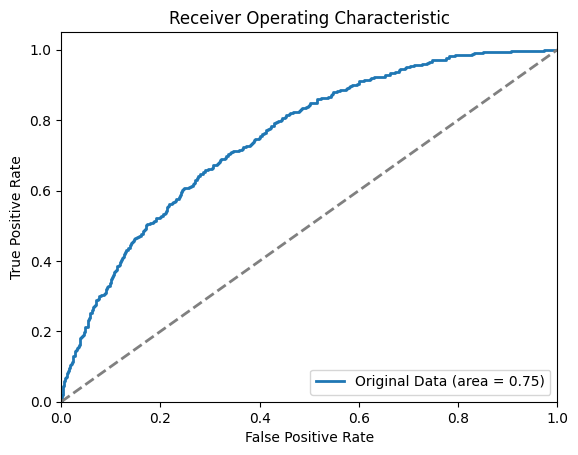

Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 29607.2520
Epoch [100/1000], Loss: 10.1470
Epoch [200/1000], Loss: 0.9621
Epoch [300/1000], Loss: 0.3311
Epoch [400/1000], Loss: 0.2265
Epoch [500/1000], Loss: 0.1792
Epoch [600/1000], Loss: 0.1495
Epoch [700/1000], Loss: 0.1308
Epoch [800/1000], Loss: 0.1304
Epoch [900/1000], Loss: 0.0898
Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 27778.6543
Epoch [100/1000], Loss: 6.2855
Epoch [200/1000], Loss: 0.8568
Epoch [300/1000], Loss: 0.3644
Epoch [400/1000], Loss: 0.2365
Epoch [500/1000], Loss: 0.1686
Epoch [600/1000], Loss: 0.1335
Epoch [700/1000], Loss: 0.1106
Epoch [800/1000], Loss: 0.0935
Epoch [900/1000], Loss: 0.0853
Started Model Training and Optimzation
Epoch [0/1000], Loss: 0.2483
Epoch [100/1000], Loss: 0.2369
Epoch [200/1000], Loss: 0.2344
Epoch [300/1000], Loss: 0.2319
Epoch [400/1000], Loss: 0.2344
Epoch [500/1000], Loss: 0.2309
Epoch [600/1000], Loss: 0.22

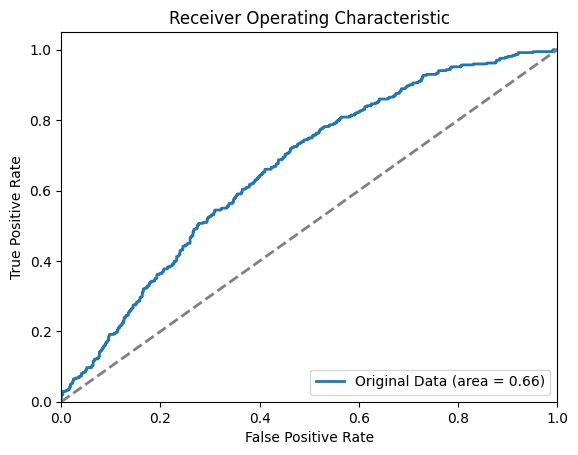

Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 306.1239
Epoch [100/1000], Loss: 0.1009
Epoch [200/1000], Loss: 0.0265
Epoch [300/1000], Loss: 0.0053
Epoch [400/1000], Loss: 0.0030
Epoch [500/1000], Loss: 0.0021
Epoch [600/1000], Loss: 0.0017
Epoch [700/1000], Loss: 0.0013
Epoch [800/1000], Loss: 0.0013
Epoch [900/1000], Loss: 0.0009
Nan Values are present in this DataFrame - Imputation started
Epoch [0/1000], Loss: 212.7610
Epoch [100/1000], Loss: 0.0938
Epoch [200/1000], Loss: 0.0203
Epoch [300/1000], Loss: 0.0041
Epoch [400/1000], Loss: 0.0016
Epoch [500/1000], Loss: 0.0011
Epoch [600/1000], Loss: 0.0008
Epoch [700/1000], Loss: 0.0010
Epoch [800/1000], Loss: 0.0005
Epoch [900/1000], Loss: 0.0004
Started Model Training and Optimzation
Epoch [0/1000], Loss: 0.2425
Epoch [100/1000], Loss: 0.2339
Epoch [200/1000], Loss: 0.2239
Epoch [300/1000], Loss: 0.2271
Epoch [400/1000], Loss: 0.2301
Epoch [500/1000], Loss: 0.2409
Epoch [600/1000], Loss: 0.2380
Ep

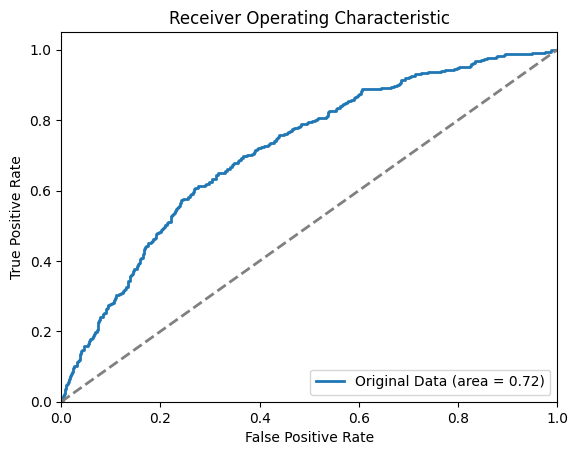

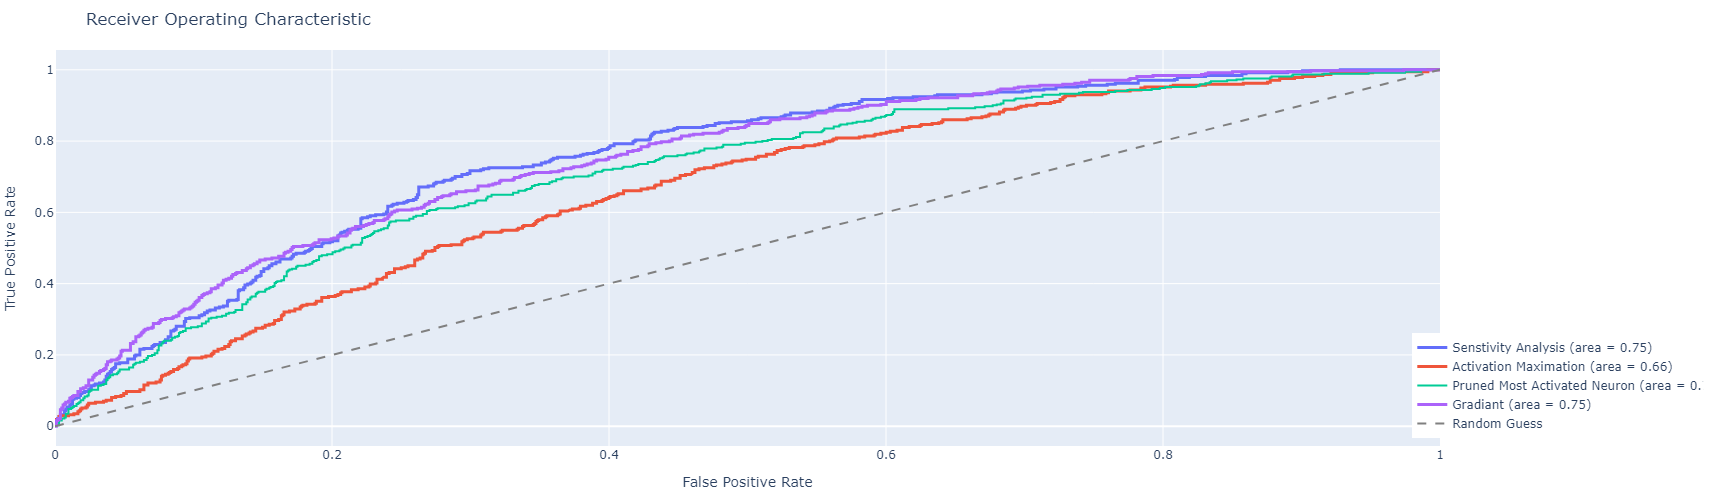

In [548]:
train_data = pd.read_csv('./Data/train_blood.csv')
test_data = pd.read_csv('./Data/test_blood.csv')
train_labels = pd.read_csv('./Data/y_train_blood.csv')
test_labels = pd.read_csv('./Data/y_test_blood.csv')

model_type = "lgbm_blood"
feature_importance_type = "..."




#____________________________ SESETIVITY ___________________________________#
ses=blood_importance_names_df["Senstivitey"][:5].values
model_name="Senstivity_covid"
feature_importance_type="..."
fpr_ses, tpr_ses,preds_ses = interpretation(train_data[ses], test_data[ses], train_labels, test_labels, model_type, feature_importance_type,model_name)
#____________________________ Gradinet ___________________________________#
grad=blood_importance_names_df["Gradinet"][:5].values
model_name="Gradinet_covid"
feature_importance_type="..."
fpr_grad, tpr_grad,preds_grad = interpretation(train_data[grad], test_data[grad], train_labels, test_labels, model_type, feature_importance_type,model_name)
#____________________________ Sigmoid ___________________________________#
sig=blood_importance_names_df["Activated Sigmoid"][:5].values
model_name="Activated Sigmoid_covid"
feature_importance_type="..."
fpr_sig, tpr_sig,preds_sig = interpretation(train_data[sig], test_data[sig], train_labels, test_labels, model_type, feature_importance_type,model_name)
#____________________________ Prune Activation ___________________________________#
prune=blood_importance_names_df["Prune Activation"][:5].values
model_name="Prune Activation_covid"
feature_importance_type="..."
fpr_prune, tpr_prune,preds_prune = interpretation(train_data[prune], test_data[prune], train_labels, test_labels, model_type, feature_importance_type,model_name)

import plotly.graph_objects as go

# Create traces
trace_original = go.Scatter(x=fpr_ses, y=tpr_ses, mode='lines', name='Senstivity Analysis (area = {:.2f})'.format(roc_auc_score(test_labels, preds_ses)), line=dict(width=3))
trace_10_percent = go.Scatter(x=fpr_grad, y=tpr_grad, mode='lines', name='Gradiant (area = {:.2f})'.format(roc_auc_score(test_labels, preds_grad)), line=dict(width=3))
trace_20_percent = go.Scatter(x=fpr_sig, y=tpr_sig, mode='lines', name='Activation Maximation (area = {:.2f})'.format(roc_auc_score(test_labels, preds_sig)), line=dict(width=3))
trace_30_percent = go.Scatter(x=fpr_prune, y=tpr_prune, mode='lines', name='Pruned Most Activated Neuron (area = {:.2f})'.format(roc_auc_score(test_labels, preds_prune), line=dict(width=3)))
line_gray = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Guess', line=dict(color='gray', dash='dash', width=2))

data = [trace_original, trace_20_percent,trace_30_percent, trace_10_percent, line_gray]

# Layout settings
layout = go.Layout(
    title='Receiver Operating Characteristic',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    legend=dict(x=0.98, y=0.02),  # Bottom right corner
    margin=dict(l=50, r=20, t=50, b=50),
    width=800,
    height=500
)

# Create figure
fig = go.Figure(data=data, layout=layout)

# Show plot
fig.show()